# Klasifikasi Tingkat Kematangan Cabai (SVM vs KNN)
Pada notebook ini kita membangun pipeline klasifikasi berbasis visi komputer untuk menentukan tingkat kematangan cabai (belum-matang, setengah-matang, matang). Fokus utama mencakup:
- Pre-processing gambar dengan peningkatan kualitas dan normalisasi ukuran.
- Ekstraksi fitur terpisah: HSV (warna), Centroid Contour Distance/CCD (bentuk), dan GLCM (tekstur).
- Seleksi fitur menggunakan PCA untuk menjaga generalisasi model.
- Pelatihan serta evaluasi model SVM dan KNN (dengan penentuan k optimal via elbow method).
- Visualisasi kunci seperti contoh preprocessing, distribusi PCA, dan performa model untuk mempermudah penyusunan laporan.

In [1]:
import os
import random
from pathlib import Path

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
RANDOM_STATE = 42
SCORING_METRIC = "balanced_accuracy"

DATASET_DIR = Path("../data/processed")
CLASS_NAMES = sorted([p.name for p in DATASET_DIR.iterdir() if p.is_dir()])
if not DATASET_DIR.exists():
	print(f"Directory not found: {DATASET_DIR}. Creating it...")
	DATASET_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = Path("../models")
print(f"Kelas yang ditemukan: {CLASS_NAMES}")

Kelas yang ditemukan: ['belum-matang', 'matang', 'setengah-matang']


## Eksplorasi Dataset
Kita mulai dengan menghitung jumlah citra per kelas dan menampilkan beberapa contoh nama file untuk memastikan struktur dataset sudah sesuai.

In [2]:
IMAGE_EXT = {".jpg", ".jpeg", ".png", ".bmp"}

def list_images(class_dir: Path):
    return [p for p in class_dir.glob("**/*") if p.suffix.lower() in IMAGE_EXT]

dataset_overview = []
for cls in CLASS_NAMES:
    files = list_images(DATASET_DIR / cls)
    dataset_overview.append({"label": cls, "jumlah_gambar": len(files)})

df_overview = pd.DataFrame(dataset_overview).sort_values("label")
display(df_overview)
print(f"Total gambar: {df_overview['jumlah_gambar'].sum()}")

sample_listing = {cls: list_images(DATASET_DIR / cls)[:3] for cls in CLASS_NAMES}
for cls, files in sample_listing.items():
    print(f"\nContoh file kelas {cls}:")
    for f in files:
        print(f"- {f.relative_to(DATASET_DIR)}")

label  jumlah_gambar
0     belum-matang             63
1           matang             60
2  setengah-matang             69

Total gambar: 192

Contoh file kelas belum-matang:
- belum-matang\image (100).jpg
- belum-matang\image (101).jpg
- belum-matang\image (102).jpg

Contoh file kelas matang:
- matang\Copy of image (70).jpg
- matang\Copy of image (71).jpg
- matang\Copy of image (72).jpg

Contoh file kelas setengah-matang:
- setengah-matang\image (1).jpg
- setengah-matang\image (10).jpg
- setengah-matang\image (11).jpg


## Pre-processing Gambar
Pipeline baru yang diterapkan sesuai kebutuhan:
1. **White balance & denoise** via Gray-World correction dilanjutkan bilateral filter sehingga warna buah konsisten dan tepi tetap tajam.
2. **Segmentasi latar** dengan konversi HSV lalu masking warna hijau tua/coklat gelap background, diteruskan morphological closing + opening untuk menyisakan buah.
3. **Kontras adaptif** memakai CLAHE pada kanal V dan histogram equalization pada grayscale guna menonjolkan tekstur permukaan.
4. **Mask-aware cropping** menggunakan bounding box mask sebelum resize 224×224 agar proporsi bentuk terjaga.

Visualisasi berikut menunjukkan tiap tahap sehingga mudah dimasukkan ke laporan.

In [3]:
IMG_SIZE = (224, 224)
CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))


def gray_world_white_balance(img_bgr: np.ndarray) -> np.ndarray:
    img = img_bgr.astype(np.float32)
    avg_bgr = img.mean(axis=(0, 1))
    gray_val = avg_bgr.mean()
    scale = gray_val / (avg_bgr + 1e-6)
    balanced = img * scale
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)
    return balanced


def keep_largest_component(binary_mask: np.ndarray) -> np.ndarray:
    labels = measure.label(binary_mask, connectivity=2)
    if labels.max() == 0:
        return binary_mask
    counts = np.bincount(labels.ravel())
    counts[0] = 0
    largest = counts.argmax()
    mask = (labels == largest).astype(np.uint8) * 255
    return mask


def build_fruit_mask(hsv_img: np.ndarray) -> np.ndarray:
    bg_green = cv2.inRange(hsv_img, (30, 40, 0), (90, 255, 200))
    bg_brown = cv2.inRange(hsv_img, (5, 30, 0), (25, 200, 150))
    background = cv2.bitwise_or(bg_green, bg_brown)

    fruit_candidate = cv2.inRange(hsv_img, (0, 40, 40), (179, 255, 255))
    mask = cv2.bitwise_and(fruit_candidate, cv2.bitwise_not(background))

    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = keep_largest_component(mask)
    return mask


def mask_aware_crop(img: np.ndarray, mask: np.ndarray, pad_ratio: float = 0.05):
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        fallback_mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
        return img.copy(), fallback_mask
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    h, w = img.shape[:2]
    pad_x = int((x_max - x_min) * pad_ratio)
    pad_y = int((y_max - y_min) * pad_ratio)
    x_min = max(x_min - pad_x, 0)
    x_max = min(x_max + pad_x, w)
    y_min = max(y_min - pad_y, 0)
    y_max = min(y_max + pad_y, h)
    cropped_img = img[y_min:y_max, x_min:x_max]
    cropped_mask = mask[y_min:y_max, x_min:x_max]
    return cropped_img, cropped_mask


def preprocess_image(path: Path) -> dict:
    img_bgr = cv2.imread(str(path))
    if img_bgr is None:
        raise ValueError(f"Gagal membaca {path}")

    img_rgb_original = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    wb = gray_world_white_balance(img_bgr)
    denoised = cv2.bilateralFilter(wb, d=9, sigmaColor=75, sigmaSpace=75)

    hsv = cv2.cvtColor(denoised, cv2.COLOR_BGR2HSV)
    mask = build_fruit_mask(hsv)

    cropped_bgr, cropped_mask = mask_aware_crop(denoised, mask)
    resized_bgr = cv2.resize(cropped_bgr, IMG_SIZE)
    resized_mask = cv2.resize(cropped_mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)

    hsv_resized = cv2.cvtColor(resized_bgr, cv2.COLOR_BGR2HSV)
    hsv_resized[:, :, 2] = CLAHE.apply(hsv_resized[:, :, 2])
    enhanced_bgr = cv2.cvtColor(hsv_resized, cv2.COLOR_HSV2BGR)

    gray = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2GRAY)
    gray_equalized = cv2.equalizeHist(gray)

    enhanced_rgb = cv2.cvtColor(enhanced_bgr, cv2.COLOR_BGR2RGB)
    normalized = enhanced_rgb.astype(np.float32) / 255.0

    return {
        "original": img_rgb_original,
        "white_balanced": cv2.cvtColor(wb, cv2.COLOR_BGR2RGB),
        "mask": resized_mask,
        "cropped": cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2RGB),
        "enhanced": enhanced_rgb,
        "hsv": hsv_resized,
        "gray_equalized": gray_equalized,
        "normalized": normalized,
    }


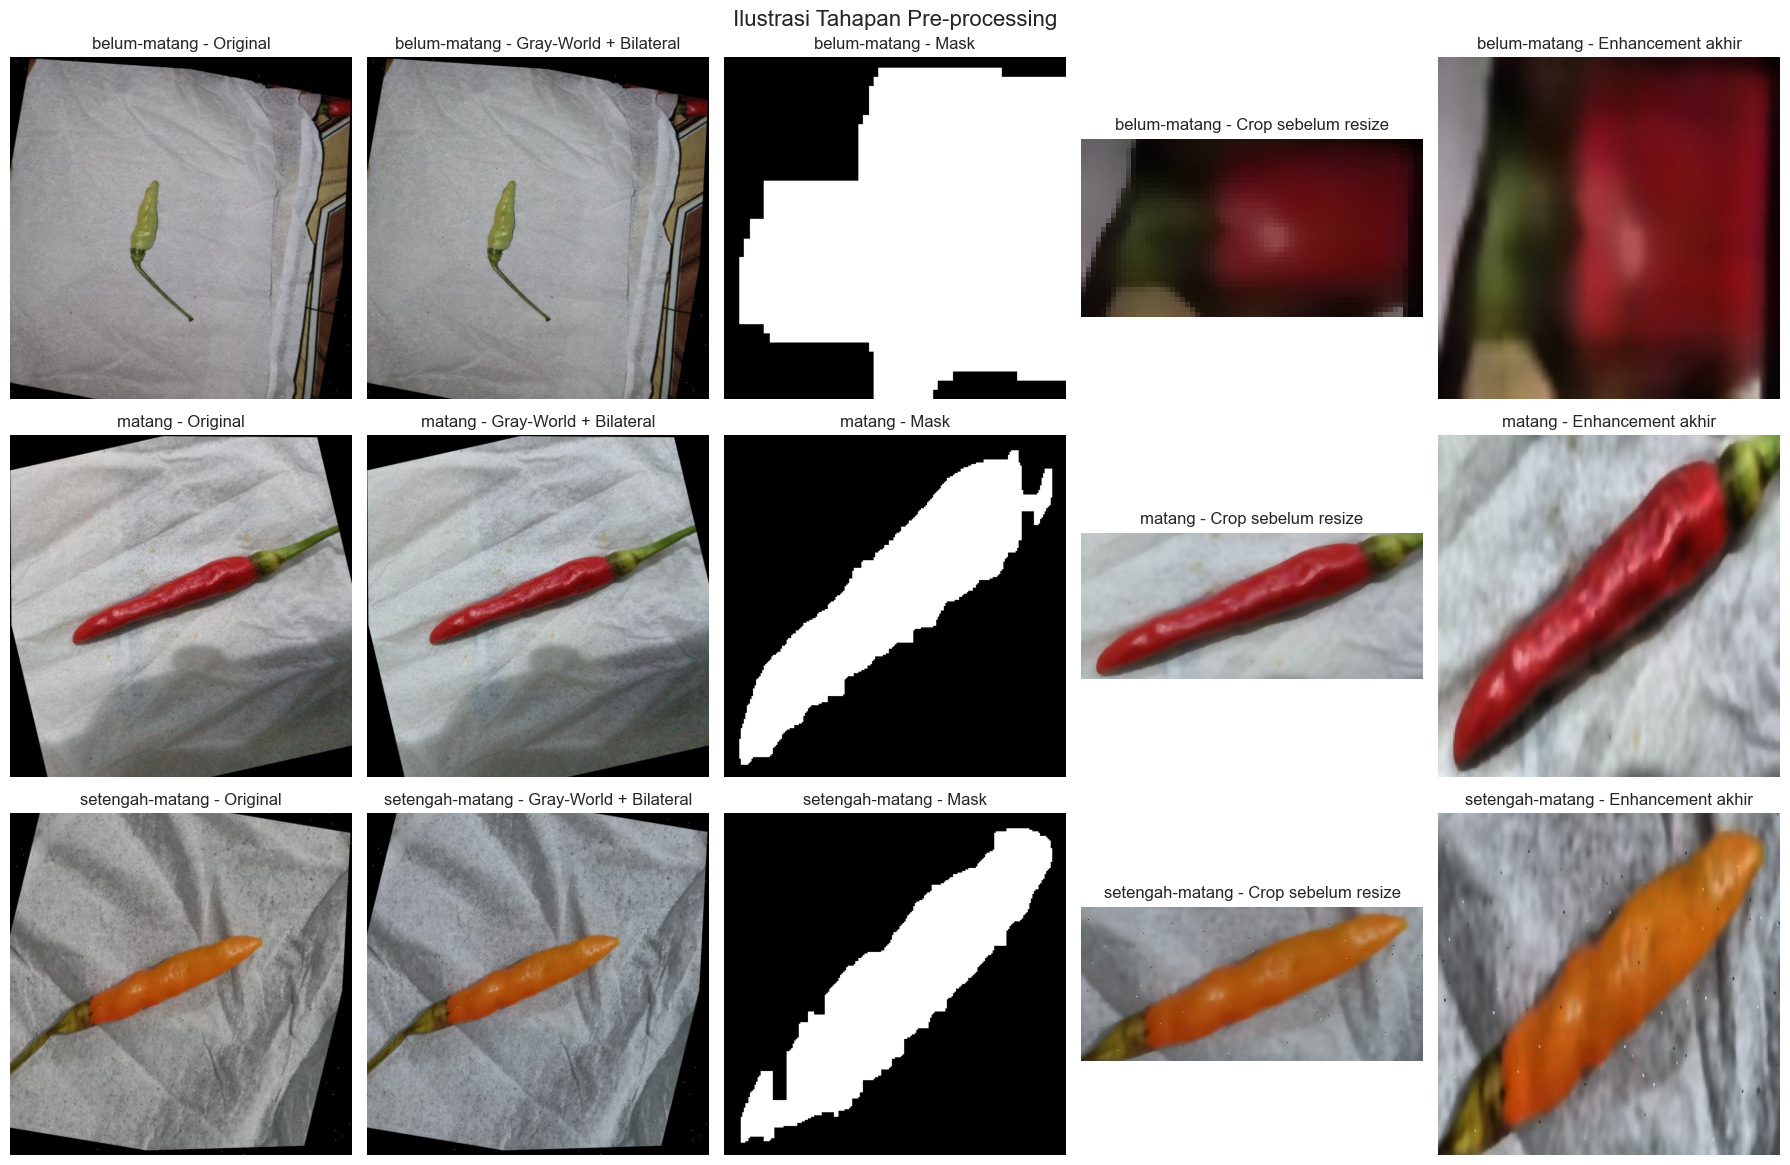

In [4]:
def plot_preprocessing_examples(samples_per_class: int = 1):
    cols = [
        "Original",
        "Gray-World + Bilateral",
        "Mask",
        "Crop sebelum resize",
        "Enhancement akhir",
    ]
    fig, axes = plt.subplots(len(CLASS_NAMES), len(cols), figsize=(18, 4 * len(CLASS_NAMES)))
    if len(CLASS_NAMES) == 1:
        axes = np.expand_dims(axes, 0)

    for row, cls in enumerate(CLASS_NAMES):
        files = list_images(DATASET_DIR / cls)
        if not files:
            continue
        sample_path = random.choice(files)
        processed = preprocess_image(sample_path)

        visual_data = [
            processed["original"],
            processed["white_balanced"],
            processed["mask"],
            processed["cropped"],
            processed["enhanced"],
        ]
        for col, ax in enumerate(axes[row]):
            if col == 2:
                ax.imshow(visual_data[col], cmap="gray")
            else:
                ax.imshow(visual_data[col])
            ax.set_title(f"{cls} - {cols[col]}")
            ax.axis("off")

    fig.suptitle("Ilustrasi Tahapan Pre-processing", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_preprocessing_examples()

## Ekstraksi Fitur (HSV, CCD, GLCM)
- **HSV**: Histogram 3 kanal (H, S, V) masing-masing 16 bin sehingga mewakili distribusi warna.
- **CCD (Centroid Contour Distance)**: Mengukur jarak kontur terbesar terhadap centroid untuk menggambarkan bentuk siluet cabai.
- **GLCM**: Statistik tekstur (contrast, correlation, energy, homogeneity) dari kanal grayscale untuk menangkap pola permukaan.

Ketiga keluarga fitur ini digabung menjadi satu vektor sehingga model memiliki representasi warna, bentuk, dan tekstur secara bersamaan.

In [5]:
def extract_hsv_features(hsv_img: np.ndarray, bins: int = 16) -> np.ndarray:
    h_hist = cv2.calcHist([hsv_img], [0], None, [bins], [0, 180])
    s_hist = cv2.calcHist([hsv_img], [1], None, [bins], [0, 256])
    v_hist = cv2.calcHist([hsv_img], [2], None, [bins], [0, 256])
    hist = np.concatenate([h_hist.flatten(), s_hist.flatten(), v_hist.flatten()])
    hist = hist / (hist.sum() + 1e-6)
    return hist.astype(np.float32)


def extract_ccd_features(mask: np.ndarray, num_points: int = 32) -> np.ndarray:
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return np.zeros(num_points, dtype=np.float32)
    cnt = max(contours, key=cv2.contourArea)
    moments = cv2.moments(cnt)
    if moments["m00"] == 0:
        return np.zeros(num_points, dtype=np.float32)

    cx = moments["m10"] / moments["m00"]
    cy = moments["m01"] / moments["m00"]
    centroid = np.array([cx, cy])
    points = cnt.reshape(-1, 2)

    vectors = points - centroid
    radii = np.linalg.norm(vectors, axis=1)
    angles = (np.arctan2(vectors[:, 1], vectors[:, 0]) + 2 * np.pi) % (2 * np.pi)

    bins = np.linspace(0, 2 * np.pi, num_points + 1)
    descriptor = np.zeros(num_points, dtype=np.float32)
    for i in range(num_points):
        mask_angle = (angles >= bins[i]) & (angles < bins[i + 1])
        if np.any(mask_angle):
            descriptor[i] = radii[mask_angle].max()
    if descriptor.max() > 0:
        descriptor /= descriptor.max()
    return descriptor


def extract_glcm_features(gray_img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    masked = cv2.bitwise_and(gray_img, gray_img, mask=mask)
    glcm = graycomatrix(
        masked,
        distances=[1, 2, 3],
        angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
        levels=256,
        symmetric=True,
        normed=True,
    )
    props = []
    for prop in ("contrast", "correlation", "energy", "homogeneity"):
        props.extend(graycoprops(glcm, prop).flatten())
    return np.array(props, dtype=np.float32)


def extract_features_from_path(path: Path) -> np.ndarray:
    processed = preprocess_image(path)
    hsv_feat = extract_hsv_features(processed["hsv"])
    gray = cv2.cvtColor(processed["enhanced"], cv2.COLOR_RGB2GRAY)
    glcm_feat = extract_glcm_features(gray, processed["mask"])
    ccd_feat = extract_ccd_features(processed["mask"])
    return np.concatenate([hsv_feat, ccd_feat, glcm_feat])


### Contoh Vektor Fitur
Berikut contoh vektor fitur gabungan untuk satu citra secara acak guna memverifikasi pipeline sebelum memproses seluruh dataset.

In [6]:
sample_path = random.choice(list_images(DATASET_DIR / CLASS_NAMES[0]))
sample_features = extract_features_from_path(sample_path)
print(f"File contoh: {sample_path.relative_to(DATASET_DIR)}")
print(f"Dimensi fitur gabungan: {sample_features.shape[0]}")

File contoh: belum-matang\image (130).jpg
Dimensi fitur gabungan: 128


## Pembuatan Dataset Fitur
Semua gambar diproses menjadi tabel fitur terstruktur yang siap digunakan oleh algoritma machine learning.

In [7]:
all_features = []
all_labels = []
all_paths = []

for cls in CLASS_NAMES:
    files = list_images(DATASET_DIR / cls)
    for path in tqdm(files, desc=f"Ekstraksi fitur {cls}"):
        feats = extract_features_from_path(path)
        all_features.append(feats)
        all_labels.append(cls)
        all_paths.append(path.name)

feature_matrix = np.vstack(all_features)
label_array = np.array(all_labels)
print(f"Matrix fitur: {feature_matrix.shape}")

Ekstraksi fitur matang:  52%|█████▏    | 31/60 [00:05<00:05,  5.75it/s]


KeyboardInterrupt: 

In [ ]:
HSV_BINS = 16
h_names = [f"h_bin_{i}" for i in range(HSV_BINS)]
s_names = [f"s_bin_{i}" for i in range(HSV_BINS)]
v_names = [f"v_bin_{i}" for i in range(HSV_BINS)]
ccd_names = [f"ccd_{i}" for i in range(32)]
_glcm_props = ("contrast", "correlation", "energy", "homogeneity")
_glcm_suffix = [
    f"{prop}_d{dist}_a{angle_idx}"
    for prop in _glcm_props
    for dist in (1, 2, 3)
    for angle_idx in range(4)
]
feature_names = h_names + s_names + v_names + ccd_names + _glcm_suffix

features_df = pd.DataFrame(feature_matrix, columns=feature_names)
features_df["label"] = label_array
features_df.head()

h_bin_0   h_bin_1   h_bin_2   h_bin_3   h_bin_4   h_bin_5   h_bin_6  \
0  0.002624  0.005188  0.145249  0.005129  0.002338  0.001946  0.001335   
1  0.001249  0.003747  0.163245  0.007427  0.006291  0.004584  0.003846   
2  0.002584  0.005720  0.149168  0.003242  0.001395  0.001495  0.000332   
3  0.025318  0.011433  0.105436  0.009168  0.005288  0.007666  0.002784   
4  0.030147  0.010071  0.102107  0.008995  0.004617  0.006637  0.004225   

    h_bin_7   h_bin_8   h_bin_9  ...  homogeneity_d1_a3  homogeneity_d2_a0  \
0  0.000943  0.013187  0.051279  ...           0.778034           0.774669   
1  0.001674  0.035063  0.083911  ...           0.764189           0.755768   
2  0.000106  0.004903  0.046377  ...           0.772135           0.763867   
3  0.000213  0.071050  0.077673  ...           0.823233           0.820745   
4  0.000864  0.060102  0.085187  ...           0.821785           0.818831   

   homogeneity_d2_a1  homogeneity_d2_a2  homogeneity_d2_a3  homogeneity_d3_a0  \
0           0.815480           0.768576           0.778034           0.749194   
1           0.794271           0.755513           0.764189           0.727057   
2           0.810306           0.765038           0.772135           0.738758   
3           0.857477           0.825913           0.823233           0.805113   
4           0.855620           0.822460           0.821785           0.802391   

   homogeneity_d3_a1  homogeneity_d3_a2  homogeneity_d3_a3         label  
0           0.770525           0.744781           0.735039  belum-matang  
1           0.742624           0.727235           0.716300  belum-matang  
2           0.764985           0.739503           0.726749  belum-matang  
3           0.823967           0.809461           0.796120  belum-matang  
4           0.823369           0.805769           0.792672  belum-matang  

[5 rows x 129 columns]

### Distribusi Label
Memastikan data relatif seimbang penting agar model tidak bias terhadap kelas tertentu.

C:\Users\Acer\AppData\Local\Temp\ipykernel_13756\3585467414.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=label_array, order=CLASS_NAMES, palette="viridis")


C:\Users\Acer\AppData\Local\Temp\ipykernel_13756\3585467414.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=label_array, order=CLASS_NAMES, palette="viridis")


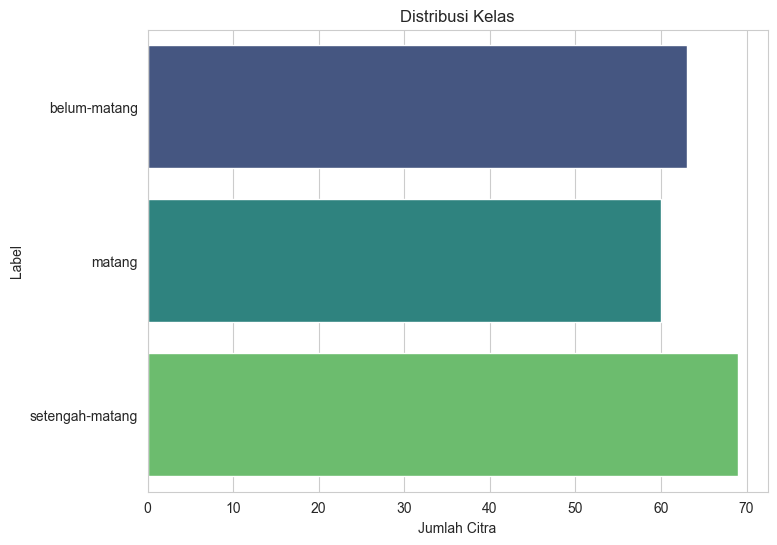

In [ ]:
sns.countplot(y=label_array, order=CLASS_NAMES, palette="viridis")
plt.title("Distribusi Kelas")
plt.xlabel("Jumlah Citra")
plt.ylabel("Label")
plt.show()

## Feature Selection dengan PCA
PCA digunakan untuk mereduksi dimensi fitur gabungan sehingga model lebih cepat dan mengurangi risiko overfitting. Variasi yang dijaga diset ke ≥95%.

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(label_array)

X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=RANDOM_STATE,
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Jumlah komponen PCA: {pca.n_components_}")
print(f"Dimensi sebelum PCA: {feature_matrix.shape[1]}, sesudah: {X_train_pca.shape[1]}")

Jumlah komponen PCA: 28
Dimensi sebelum PCA: 128, sesudah: 28


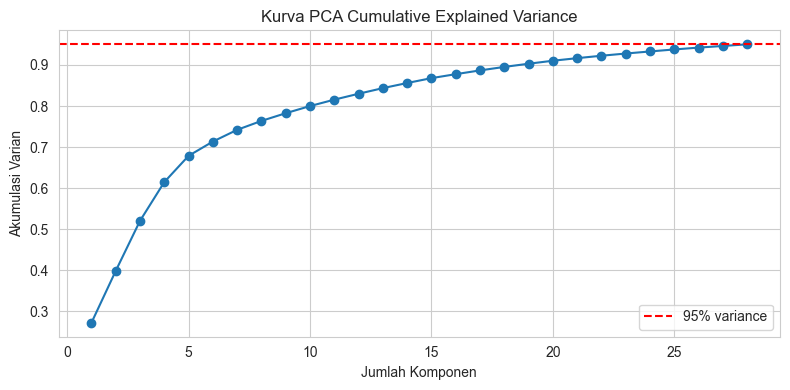

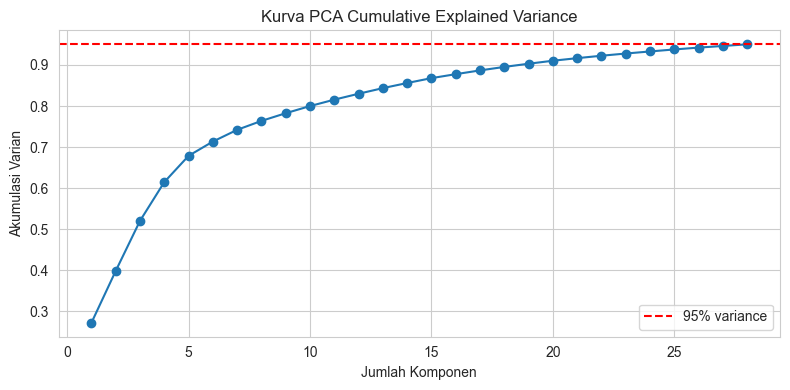

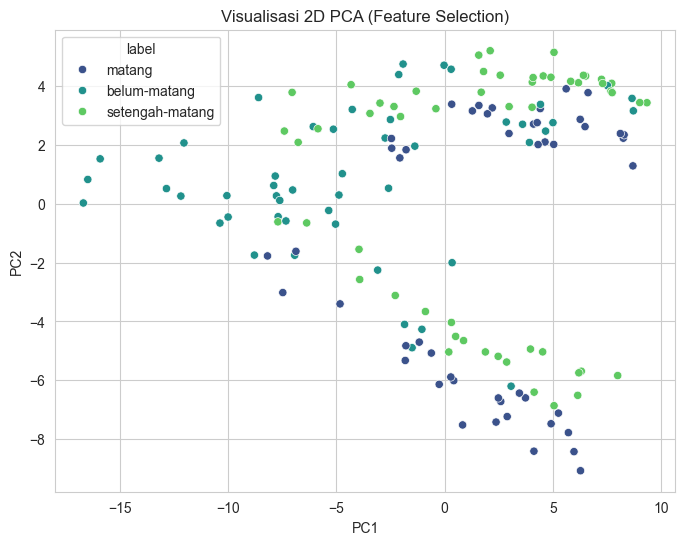

In [ ]:
explained = pca.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(explained) + 1), np.cumsum(explained), marker="o")
plt.axhline(0.95, color="red", linestyle="--", label="95% variance")
plt.xlabel("Jumlah Komponen")
plt.ylabel("Akumulasi Varian")
plt.title("Kurva PCA Cumulative Explained Variance")
plt.legend()
plt.tight_layout()
plt.show()

pca_df = pd.DataFrame(
    X_train_pca[:, :2],
    columns=["PC1", "PC2"],
)
pca_df["label"] = label_encoder.inverse_transform(y_train)
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="viridis")
plt.title("Visualisasi 2D PCA (Feature Selection)")
plt.show()

## Pelatihan Model & Evaluasi
Setelah fitur direduksi dengan PCA, kita latih dua algoritma secara terpisah:
- **SVM (RBF kernel)** dengan pencarian grid sederhana.
- **KNN** dengan penentuan jumlah tetangga terbaik menggunakan elbow method berbasis validasi silang stratified.

Evaluasi dilakukan pada data uji yang sepenuhnya tidak terlihat saat training.

In [ ]:
def plot_confusion(cm: np.ndarray, labels: list[str], title: str):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_tr, y_tr, X_te, y_te, label_names: list[str]):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    acc = accuracy_score(y_te, preds)
    bal_acc = balanced_accuracy_score(y_te, preds)
    macro_f1 = f1_score(y_te, preds, average="macro")
    print(f"Akurasi: {acc:.3f}")
    print(f"Balanced Accuracy: {bal_acc:.3f}")
    print(f"Macro F1: {macro_f1:.3f}")
    print(classification_report(y_te, preds, target_names=label_names))
    cm = confusion_matrix(y_te, preds)
    plot_confusion(cm, label_names, f"Confusion Matrix - {model.__class__.__name__}")
    metrics = {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "macro_f1": macro_f1,
    }
    return metrics, preds

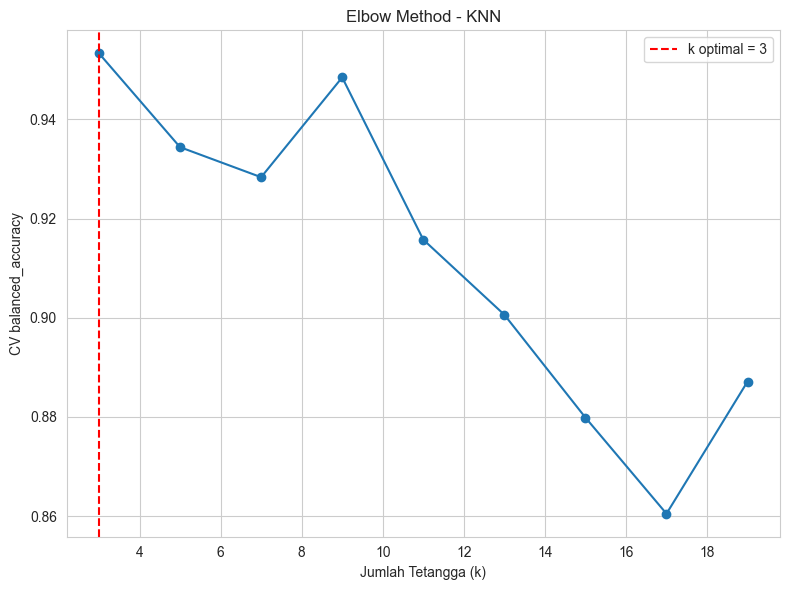

Nilai k terbaik menurut elbow (berdasarkan balanced_accuracy): 3


In [ ]:
k_values = list(range(3, 21, 2))
cv_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=skf, scoring=SCORING_METRIC)
    cv_scores.append(scores.mean())

best_k = k_values[int(np.argmax(cv_scores))]
plt.plot(k_values, cv_scores, marker="o")
plt.xlabel("Jumlah Tetangga (k)")
plt.ylabel(f"CV {SCORING_METRIC}")
plt.title("Elbow Method - KNN")
plt.axvline(best_k, color="red", linestyle="--", label=f"k optimal = {best_k}")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Nilai k terbaik menurut elbow (berdasarkan {SCORING_METRIC}): {best_k}")

SVM parameter terbaik: {'C': 1, 'gamma': 0.01}
Akurasi: 1.000
Balanced Accuracy: 1.000
Macro F1: 1.000
                 precision    recall  f1-score   support

   belum-matang       1.00      1.00      1.00        13
         matang       1.00      1.00      1.00        12
setengah-matang       1.00      1.00      1.00        14

       accuracy                           1.00        39
      macro avg       1.00      1.00      1.00        39
   weighted avg       1.00      1.00      1.00        39



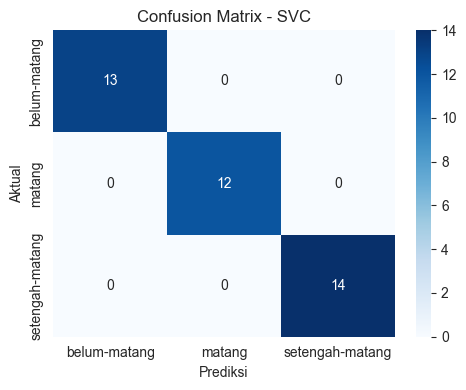

In [ ]:
svm_params = {
    "C": [0.1, 1, 10],
    "gamma": [0.01, 0.1, 1],
}
svm_grid = GridSearchCV(
    SVC(kernel="rbf", class_weight="balanced", probability=True),
    param_grid=svm_params,
    cv=skf,
    n_jobs=-1,
    scoring=SCORING_METRIC,
 )
svm_grid.fit(X_train_pca, y_train)
print(f"SVM parameter terbaik: {svm_grid.best_params_}")
svm_best = svm_grid.best_estimator_
svm_metrics, svm_preds = evaluate_model(
    svm_best, X_train_pca, y_train, X_test_pca, y_test, label_encoder.classes_.tolist()
 )

Akurasi: 0.974
Balanced Accuracy: 0.974
Macro F1: 0.975
                 precision    recall  f1-score   support

   belum-matang       1.00      0.92      0.96        13
         matang       1.00      1.00      1.00        12
setengah-matang       0.93      1.00      0.97        14

       accuracy                           0.97        39
      macro avg       0.98      0.97      0.98        39
   weighted avg       0.98      0.97      0.97        39



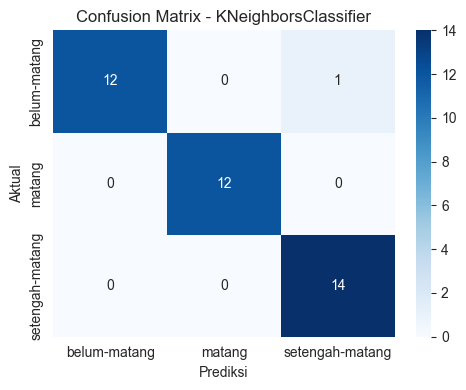

In [ ]:
knn_best = KNeighborsClassifier(n_neighbors=11, weights="distance", metric="euclidean")
knn_metrics, knn_preds = evaluate_model(
    knn_best, X_train_pca, y_train, X_test_pca, y_test, label_encoder.classes_.tolist()
 )

## Perbandingan Akurasi
Ringkasan performa model untuk mempermudah interpretasi laporan.

Model  Accuracy  Balanced Accuracy  Macro F1
0  SVM (RBF)  1.000000           1.000000  1.000000
1  KNN (k=3)  0.974359           0.974359  0.975172

Model  Accuracy  Balanced Accuracy  Macro F1
0  SVM (RBF)  1.000000           1.000000  1.000000
1  KNN (k=3)  0.974359           0.974359  0.975172

C:\Users\Acer\AppData\Local\Temp\ipykernel_13756\3657955559.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Balanced Accuracy", palette="mako")


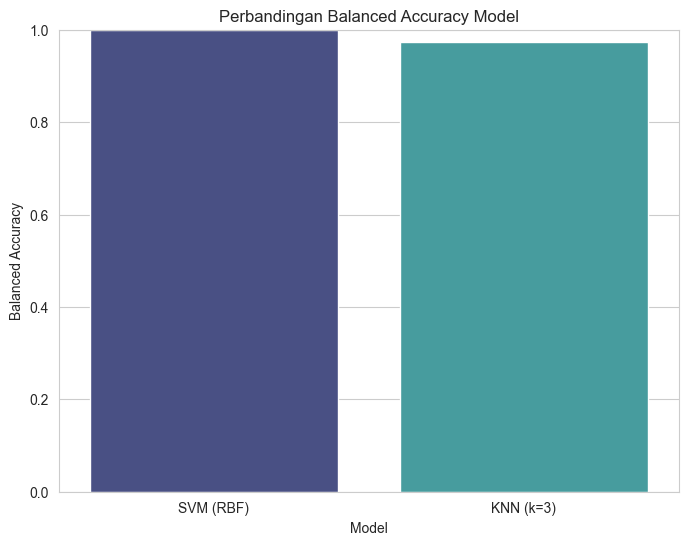

In [ ]:
results_df = pd.DataFrame(
    {
        "Model": ["SVM (RBF)", f"KNN (k={best_k})"],
        "Accuracy": [svm_metrics["accuracy"], knn_metrics["accuracy"]],
        "Balanced Accuracy": [svm_metrics["balanced_accuracy"], knn_metrics["balanced_accuracy"]],
        "Macro F1": [svm_metrics["macro_f1"], knn_metrics["macro_f1"]],
    }
)
display(results_df)

sns.barplot(data=results_df, x="Model", y="Balanced Accuracy", palette="mako")
plt.ylim(0, 1)
plt.title("Perbandingan Balanced Accuracy Model")
plt.show()

## Ekspor Pipeline ke `.pkl`
Baik SVM maupun KNN diserialisasi terpisah sehingga backend bisa membandingkan hasil keduanya pada saat inferensi.

In [ ]:
SVM_ARTIFACT = MODEL_DIR / "ripeness_svm.pkl"
KNN_ARTIFACT = MODEL_DIR / f"ripeness_knn_k{best_k}.pkl"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

feature_meta = {
    "hsv_bins": HSV_BINS,
    "ccd_points": 32,
    "glcm_distances": [1, 2, 3],
    "glcm_angles": [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4],
}

def build_payload(model, model_name: str, metrics: dict, extra_meta: dict | None = None):
    metadata = {
        "model_name": model_name,
        "accuracy": float(metrics["accuracy"]),
        "balanced_accuracy": float(metrics["balanced_accuracy"]),
        "macro_f1": float(metrics["macro_f1"]),
        "classes": label_encoder.classes_.tolist(),
        "created_at": pd.Timestamp.utcnow().isoformat(),
    }
    if extra_meta:
        metadata.update(extra_meta)
    return {
        "scaler": scaler,
        "pca": pca,
        "model": model,
        "label_encoder": label_encoder,
        "feature_version": feature_meta,
        "metadata": metadata,
    }

svm_payload = build_payload(
    svm_best,
    model_name="SVM (RBF)",
    metrics=svm_metrics,
    extra_meta={"best_params": svm_grid.best_params_},
 )
knn_payload = build_payload(
    knn_best,
    model_name=f"KNN (k={best_k})",
    metrics=knn_metrics,
    extra_meta={"k": best_k},
 )

joblib.dump(svm_payload, SVM_ARTIFACT)
joblib.dump(knn_payload, KNN_ARTIFACT)

print(f"SVM pipeline tersimpan di: {SVM_ARTIFACT.resolve()}")
print(f"KNN pipeline tersimpan di: {KNN_ARTIFACT.resolve()}")

SVM pipeline tersimpan di: C:\Users\Acer\Project\chili-scan\backend\models\ripeness_svm.pkl
KNN pipeline tersimpan di: C:\Users\Acer\Project\chili-scan\backend\models\ripeness_knn_k3.pkl


## Fungsi Klasifikasi Gambar Baru
Inferensi memuat kedua artefak (SVM & KNN), menghitung prediksi terpisah, lalu memberikan rekomendasi model berdasarkan performa validasi.

In [ ]:
def classify_single_image(
    image_path,
    svm_artifact: Path = SVM_ARTIFACT,
    knn_artifact: Path = KNN_ARTIFACT,
 ):
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"File tidak ditemukan: {image_path}")

    svm_artifact = Path(svm_artifact)
    knn_artifact = Path(knn_artifact)
    for artifact in (svm_artifact, knn_artifact):
        if not artifact.exists():
            raise FileNotFoundError(f"Artifact belum tersedia: {artifact}")

    features = extract_features_from_path(image_path)

    def predict_with(artifact: Path):
        pipeline = joblib.load(artifact)
        scaler = pipeline["scaler"]
        pca_model = pipeline["pca"]
        model = pipeline["model"]
        encoder = pipeline["label_encoder"]
        metadata = pipeline.get("metadata", {})

        features_scaled = scaler.transform([features])
        if pca_model is not None:
            features_transformed = pca_model.transform(features_scaled)
        else:
            features_transformed = features_scaled

        pred_idx = model.predict(features_transformed)[0]
        pred_label = encoder.inverse_transform([pred_idx])[0]

        if hasattr(model, "predict_proba"):
            probas = model.predict_proba(features_transformed)[0]
            prob_map = {label: float(prob) for label, prob in zip(encoder.classes_, probas)}
            confidence = prob_map.get(pred_label)
        else:
            prob_map = None
            confidence = None

        return {
            "model": metadata.get("model_name", model.__class__.__name__),
            "prediction": pred_label,
            "probabilities": prob_map,
            "confidence": confidence,
            "artifact": str(artifact.resolve()),
            "metadata": metadata,
        }

    svm_result = predict_with(svm_artifact)
    knn_result = predict_with(knn_artifact)

    def ranking_key(result):
        meta = result["metadata"]
        return (
            meta.get("balanced_accuracy", meta.get("accuracy", 0.0)),
            result.get("confidence") or 0.0,
        )

    ranked = sorted([svm_result, knn_result], key=ranking_key, reverse=True)
    top = ranked[0]
    bal_acc = top["metadata"].get("balanced_accuracy")
    acc = top["metadata"].get("accuracy")
    if bal_acc is not None:
        reason = f"Balanced accuracy validasi tertinggi ({bal_acc:.3f})"
    elif acc is not None:
        reason = f"Akurasi validasi lebih tinggi ({acc:.3f})"
    else:
        reason = None

    return {
        "image": image_path.name,
        "svm": svm_result,
        "knn": knn_result,
        "recommended_model": top["model"],
        "recommendation_reason": reason,
    }


def predictions_to_table(results: list[dict]) -> pd.DataFrame:
    rows = []
    for result in results:
        for model_key in ("svm", "knn"):
            model_result = result[model_key]
            rows.append(
                {
                    "Image": result["image"],
                    "Model": model_result["model"],
                    "Prediction": model_result["prediction"],
                    "Confidence": model_result.get("confidence"),
                    "Accuracy": model_result["metadata"].get("accuracy"),
                    "Balanced Accuracy": model_result["metadata"].get("balanced_accuracy"),
                    "Macro F1": model_result["metadata"].get("macro_f1"),
                    "Recommended": model_result["model"] == result["recommended_model"],
                    "Reason": result.get("recommendation_reason") if model_result["model"] == result["recommended_model"] else None,
                }
            )
    df = pd.DataFrame(rows)
    return df.sort_values(["Image", "Recommended"], ascending=[True, False]).reset_index(drop=True)


example_images = [
    Path("../data/example/cabai-matang.jpeg"),
    Path("../data/example/cabai-setengah-matang.jpeg"),
    Path("../data/example/tomat-matang.jpeg"),
    Path("../data/example/tomat-belum-matang.jpeg"),
    Path("../data/example/carolina-matang.jpeg"),
    Path("../data/example/carolina-stengah-matang.jpeg"),
    Path("../data/example/cabai-dataset-matang.jpg"),
    Path("../data/example/cabai-dataset-setengah-matang.jpg"),
    Path("../data/example/cabai-dataset-belum-matang.jpg"),
    Path("../data/example/penghapus.png"),
 ]
classification_results = []
for img_path in example_images:
    if img_path.exists():
        classification_results.append(classify_single_image(img_path))
    else:
        print(f"Peringatan: file tidak ditemukan {img_path}")

if classification_results:
    display(predictions_to_table(classification_results))

Image      Model       Prediction  Confidence  \
0      cabai-dataset-belum-matang.jpg  SVM (RBF)     belum-matang    0.978591   
1      cabai-dataset-belum-matang.jpg  KNN (k=3)     belum-matang    0.999997   
2            cabai-dataset-matang.jpg  SVM (RBF)           matang    0.980201   
3            cabai-dataset-matang.jpg  KNN (k=3)           matang    0.999999   
4   cabai-dataset-setengah-matang.jpg  SVM (RBF)  setengah-matang    0.991373   
5   cabai-dataset-setengah-matang.jpg  KNN (k=3)  setengah-matang    1.000000   
6                   cabai-matang.jpeg  SVM (RBF)     belum-matang    0.836670   
7                   cabai-matang.jpeg  KNN (k=3)     belum-matang    0.463275   
8          cabai-setengah-matang.jpeg  SVM (RBF)     belum-matang    0.836670   
9          cabai-setengah-matang.jpeg  KNN (k=3)     belum-matang    0.903625   
10               carolina-matang.jpeg  SVM (RBF)     belum-matang    0.836670   
11               carolina-matang.jpeg  KNN (k=3)     belum-matang    0.552720   
12       carolina-stengah-matang.jpeg  SVM (RBF)     belum-matang    0.836670   
13       carolina-stengah-matang.jpeg  KNN (k=3)     belum-matang    0.643712   
14                      penghapus.png  SVM (RBF)     belum-matang    0.836670   
15                      penghapus.png  KNN (k=3)     belum-matang    0.647817   
16            tomat-belum-matang.jpeg  SVM (RBF)     belum-matang    0.826385   
17            tomat-belum-matang.jpeg  KNN (k=3)     belum-matang    0.548601   
18                  tomat-matang.jpeg  SVM (RBF)     belum-matang    0.817607   
19                  tomat-matang.jpeg  KNN (k=3)           matang    0.550089   

    Accuracy  Balanced Accuracy  Macro F1  Recommended  \
0   1.000000           1.000000  1.000000         True   
1   0.974359           0.974359  0.975172        False   
2   1.000000           1.000000  1.000000         True   
3   0.974359           0.974359  0.975172        False   
4   1.000000           1.000000  1.000000         True   
5   0.974359           0.974359  0.975172        False   
6   1.000000           1.000000  1.000000         True   
7   0.974359           0.974359  0.975172        False   
8   1.000000           1.000000  1.000000         True   
9   0.974359           0.974359  0.975172        False   
10  1.000000           1.000000  1.000000         True   
11  0.974359           0.974359  0.975172        False   
12  1.000000           1.000000  1.000000         True   
13  0.974359           0.974359  0.975172        False   
14  1.000000           1.000000  1.000000         True   
15  0.974359           0.974359  0.975172        False   
16  1.000000           1.000000  1.000000         True   
17  0.974359           0.974359  0.975172        False   
18  1.000000           1.000000  1.000000         True   
19  0.974359           0.974359  0.975172        False   

                                          Reason  
0   Balanced accuracy validasi tertinggi (1.000)  
1                                           None  
2   Balanced accuracy validasi tertinggi (1.000)  
3                                           None  
4   Balanced accuracy validasi tertinggi (1.000)  
5                                           None  
6   Balanced accuracy validasi tertinggi (1.000)  
7                                           None  
8   Balanced accuracy validasi tertinggi (1.000)  
9                                           None  
10  Balanced accuracy validasi tertinggi (1.000)  
11                                          None  
12  Balanced accuracy validasi tertinggi (1.000)  
13                                          None  
14  Balanced accuracy validasi tertinggi (1.000)  
15                                          None  
16  Balanced accuracy validasi tertinggi (1.000)  
17                                          None  
18  Balanced accuracy validasi tertinggi (1.000)  
19                                          None

## Visualisasi Detail Hasil Klasifikasi
Fungsi untuk menampilkan gambar yang diklasifikasi beserta detail prediksi, probabilitas, dan metrik model dalam satu tampilan yang informatif.

In [ ]:
def visualize_classification_result(
    image_path,
    result: dict,
    show_preprocessing: bool = True,
    figsize: tuple = (18, 8)
):
    """
    Visualisasi komprehensif hasil klasifikasi dengan gambar, preprocessing steps, 
    probabilitas, dan metrik model.
    
    Parameters:
    -----------
    image_path : Path or str
        Path ke gambar yang diklasifikasi
    result : dict
        Hasil dari classify_single_image() atau classify_single_image_with_detection()
    show_preprocessing : bool
        Tampilkan tahap preprocessing atau tidak
    figsize : tuple
        Ukuran figure
    """
    image_path = Path(image_path)
    
    # Proses gambar untuk mendapatkan tahapan preprocessing
    proc = preprocess_image(image_path)
    
    # Cek apakah ada deteksi cabai
    is_chili = result.get("is_chili", True)
    
    if show_preprocessing:
        # Layout: 3 baris x 4 kolom
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        # Baris 1: Tahapan Preprocessing
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(proc["original"])
        ax1.set_title("Original Image", fontweight="bold")
        ax1.axis("off")
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(proc["white_balanced"])
        ax2.set_title("White Balanced", fontweight="bold")
        ax2.axis("off")
        
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.imshow(proc["mask"], cmap="gray")
        mask_pct = (proc["mask"] > 0).sum() / proc["mask"].size * 100
        ax3.set_title(f"Mask ({mask_pct:.1f}% area)", fontweight="bold")
        ax3.axis("off")
        
        ax4 = fig.add_subplot(gs[0, 3])
        ax4.imshow(proc["enhanced"])
        ax4.set_title("Enhanced (CLAHE)", fontweight="bold")
        ax4.axis("off")
        
        # Baris 2: Grafik Probabilitas SVM & KNN
        svm_r = result["svm"]
        knn_r = result["knn"]
        
        if is_chili and svm_r["probabilities"]:
            ax5 = fig.add_subplot(gs[1, :2])
            classes = list(svm_r["probabilities"].keys())
            probs = list(svm_r["probabilities"].values())
            colors = ['#2ecc71' if c == svm_r["prediction"] else '#95a5a6' for c in classes]
            bars = ax5.barh(classes, probs, color=colors)
            ax5.set_xlabel("Probabilitas", fontweight="bold")
            ax5.set_title(f"🤖 SVM Prediction: {svm_r['prediction']}", fontweight="bold", fontsize=12)
            ax5.set_xlim(0, 1)
            for i, (bar, prob) in enumerate(zip(bars, probs)):
                ax5.text(prob + 0.02, i, f"{prob:.3f}", va="center", fontweight="bold")
        else:
            ax5 = fig.add_subplot(gs[1, :2])
            ax5.text(0.5, 0.5, "❌ BUKAN CABAI\n(SVM tidak dijalankan)", 
                    ha="center", va="center", fontsize=14, fontweight="bold", color="red")
            ax5.axis("off")
        
        if is_chili and knn_r["probabilities"]:
            ax6 = fig.add_subplot(gs[1, 2:])
            classes = list(knn_r["probabilities"].keys())
            probs = list(knn_r["probabilities"].values())
            colors = ['#3498db' if c == knn_r["prediction"] else '#95a5a6' for c in classes]
            bars = ax6.barh(classes, probs, color=colors)
            ax6.set_xlabel("Probabilitas", fontweight="bold")
            ax6.set_title(f"🤖 KNN Prediction: {knn_r['prediction']}", fontweight="bold", fontsize=12)
            ax6.set_xlim(0, 1)
            for i, (bar, prob) in enumerate(zip(bars, probs)):
                ax6.text(prob + 0.02, i, f"{prob:.3f}", va="center", fontweight="bold")
        else:
            ax6 = fig.add_subplot(gs[1, 2:])
            ax6.text(0.5, 0.5, "❌ BUKAN CABAI\n(KNN tidak dijalankan)", 
                    ha="center", va="center", fontsize=14, fontweight="bold", color="red")
            ax6.axis("off")
        
        # Baris 3: Metrik Model & Info
        ax7 = fig.add_subplot(gs[2, :2])
        ax7.axis("off")
        
        if is_chili:
            info_text = f"""
📊 METRIK MODEL SVM
━━━━━━━━━━━━━━━━━━━━
• Prediction: {svm_r['prediction']}
• Confidence: {svm_r['confidence']:.1%}
• Accuracy: {svm_r['metadata']['accuracy']:.1%}
• Balanced Acc: {svm_r['metadata']['balanced_accuracy']:.1%}
• Macro F1: {svm_r['metadata']['macro_f1']:.3f}

Best Params: {svm_r['metadata'].get('best_params', 'N/A')}
"""
        else:
            detection_details = result.get("detection_details", {})
            checks = detection_details.get("checks", {})
            info_text = f"""
🔍 DETEKSI NON-CABAI
━━━━━━━━━━━━━━━━━━━━
Status: ❌ BUKAN CABAI

Kriteria yang dicek:
"""
            for check_name, passed in checks.items():
                icon = "✓" if passed else "✗"
                info_text += f"  {icon} {check_name}\n"
            
            info_text += f"\nPassed: {detection_details.get('passed_checks', 0)}/{detection_details.get('total_checks', 5)}"
        
        ax7.text(0, 0.5, info_text, fontsize=10, family="monospace", 
                verticalalignment="center")
        
        ax8 = fig.add_subplot(gs[2, 2:])
        ax8.axis("off")
        
        if is_chili:
            info_text2 = f"""
📊 METRIK MODEL KNN
━━━━━━━━━━━━━━━━━━━━
• Prediction: {knn_r['prediction']}
• Confidence: {knn_r['confidence']:.1%}
• Accuracy: {knn_r['metadata']['accuracy']:.1%}
• Balanced Acc: {knn_r['metadata']['balanced_accuracy']:.1%}
• Macro F1: {knn_r['metadata']['macro_f1']:.3f}

k = {knn_r['metadata'].get('k', 'N/A')}
"""
        else:
            info_text2 = f"""
📝 REKOMENDASI
━━━━━━━━━━━━━━━━━━━━
{result.get('recommendation_reason', 'Gambar bukan cabai')}

Gambar ini kemungkinan:
• Bentuk terlalu bulat (bukan cabai)
• Background/tekstur tidak sesuai
• Objek lain (tomat, buah lain, dll)

Silakan gunakan gambar cabai 
untuk klasifikasi.
"""
        
        ax8.text(0, 0.5, info_text2, fontsize=10, family="monospace", 
                verticalalignment="center")
        
        # Title utama
        if is_chili:
            recommended = result.get("recommended_model", "N/A")
            fig.suptitle(
                f"📷 {result['image']} | 🏆 Recommended: {recommended}", 
                fontsize=16, fontweight="bold"
            )
        else:
            fig.suptitle(
                f"📷 {result['image']} | ❌ BUKAN CABAI (Non-Chili Detected)", 
                fontsize=16, fontweight="bold", color="red"
            )
    else:
        # Layout sederhana: hanya gambar dan probabilitas
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Gambar original
        axes[0].imshow(proc["original"])
        axes[0].set_title("Input Image", fontweight="bold", fontsize=14)
        axes[0].axis("off")
        
        # Probabilitas SVM
        if is_chili and result["svm"]["probabilities"]:
            svm_r = result["svm"]
            classes = list(svm_r["probabilities"].keys())
            probs = list(svm_r["probabilities"].values())
            colors = ['#2ecc71' if c == svm_r["prediction"] else '#95a5a6' for c in classes]
            axes[1].barh(classes, probs, color=colors)
            axes[1].set_xlabel("Probabilitas", fontweight="bold")
            axes[1].set_title(f"SVM: {svm_r['prediction']} ({svm_r['confidence']:.1%})", 
                            fontweight="bold", fontsize=14)
            axes[1].set_xlim(0, 1)
        else:
            axes[1].text(0.5, 0.5, "❌ BUKAN CABAI", 
                        ha="center", va="center", fontsize=16, fontweight="bold", color="red")
            axes[1].axis("off")
        
        # Probabilitas KNN
        if is_chili and result["knn"]["probabilities"]:
            knn_r = result["knn"]
            classes = list(knn_r["probabilities"].keys())
            probs = list(knn_r["probabilities"].values())
            colors = ['#3498db' if c == knn_r["prediction"] else '#95a5a6' for c in classes]
            axes[2].barh(classes, probs, color=colors)
            axes[2].set_xlabel("Probabilitas", fontweight="bold")
            axes[2].set_title(f"KNN: {knn_r['prediction']} ({knn_r['confidence']:.1%})", 
                            fontweight="bold", fontsize=14)
            axes[2].set_xlim(0, 1)
        else:
            axes[2].text(0.5, 0.5, "❌ BUKAN CABAI", 
                        ha="center", va="center", fontsize=16, fontweight="bold", color="red")
            axes[2].axis("off")
        
        recommended = result.get("recommended_model", "N/A")
        fig.suptitle(f"📷 {result['image']} | 🏆 {recommended}", 
                    fontsize=16, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


print("✓ Fungsi visualize_classification_result() telah didefinisikan")
print("\nCara menggunakan:")
print("  result = classify_single_image('path/to/image.jpg')")
print("  visualize_classification_result('path/to/image.jpg', result)")
print("  # Atau versi simple:")
print("  visualize_classification_result('path/to/image.jpg', result, show_preprocessing=False)")

✓ Fungsi visualize_classification_result() telah didefinisikan

Cara menggunakan:
  result = classify_single_image('path/to/image.jpg')
  visualize_classification_result('path/to/image.jpg', result)
  # Atau versi simple:
  visualize_classification_result('path/to/image.jpg', result, show_preprocessing=False)


VISUALISASI HASIL KLASIFIKASI


Memproses: cabai-matang.jpeg


C:\Users\Acer\AppData\Local\Temp\ipykernel_13756\1414029405.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  

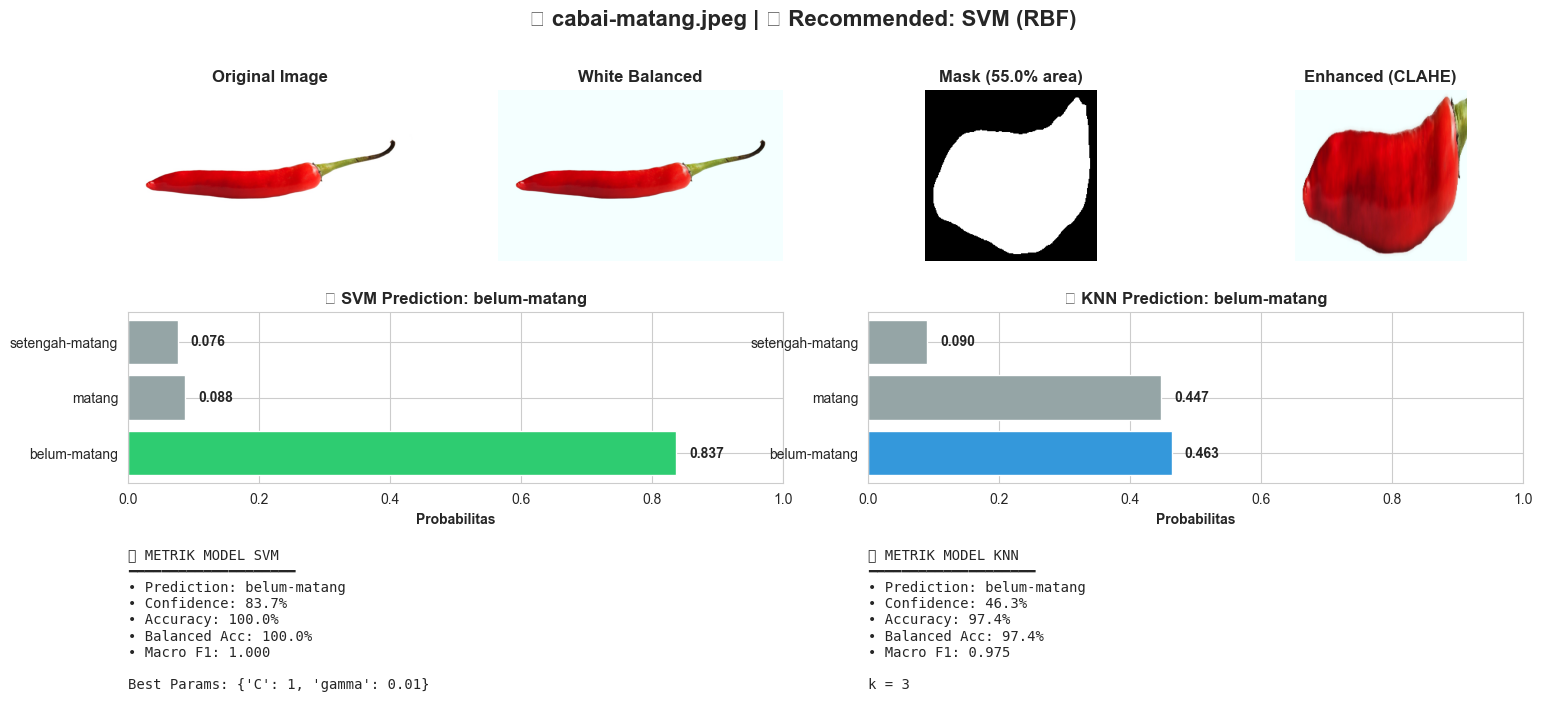


Memproses: cabai-setengah-matang.jpeg


C:\Users\Acer\AppData\Local\Temp\ipykernel_13756\1414029405.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  

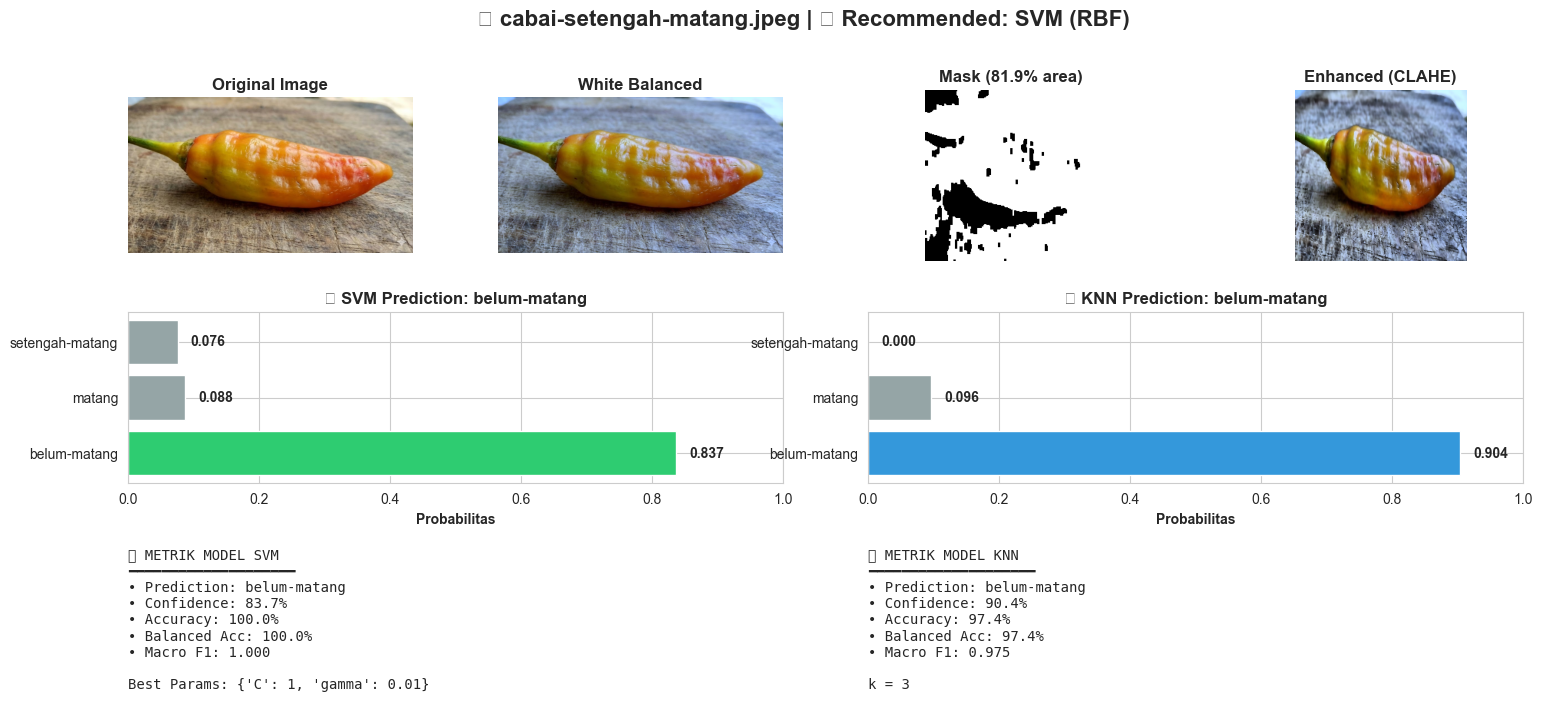


Memproses: tomat-matang.jpeg


c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


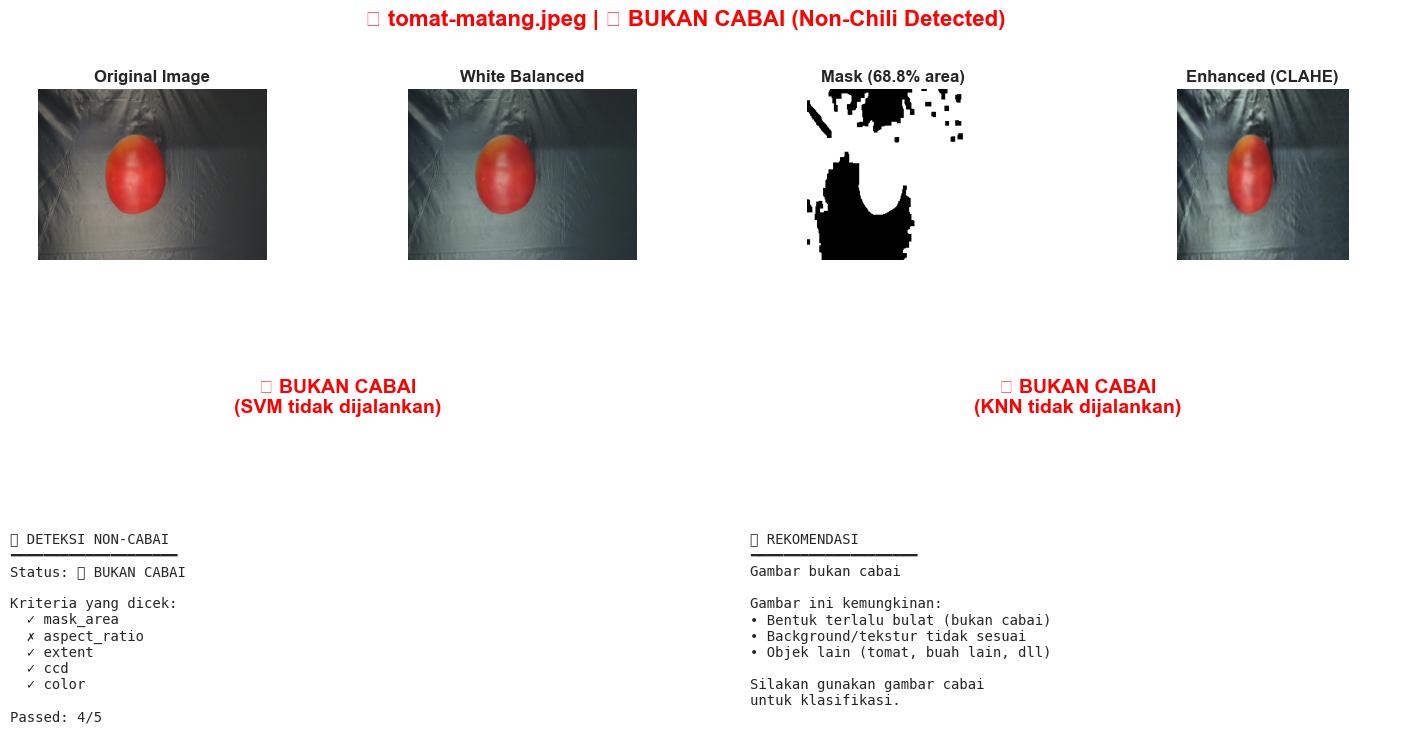


Memproses: tomat-belum-matang.jpeg


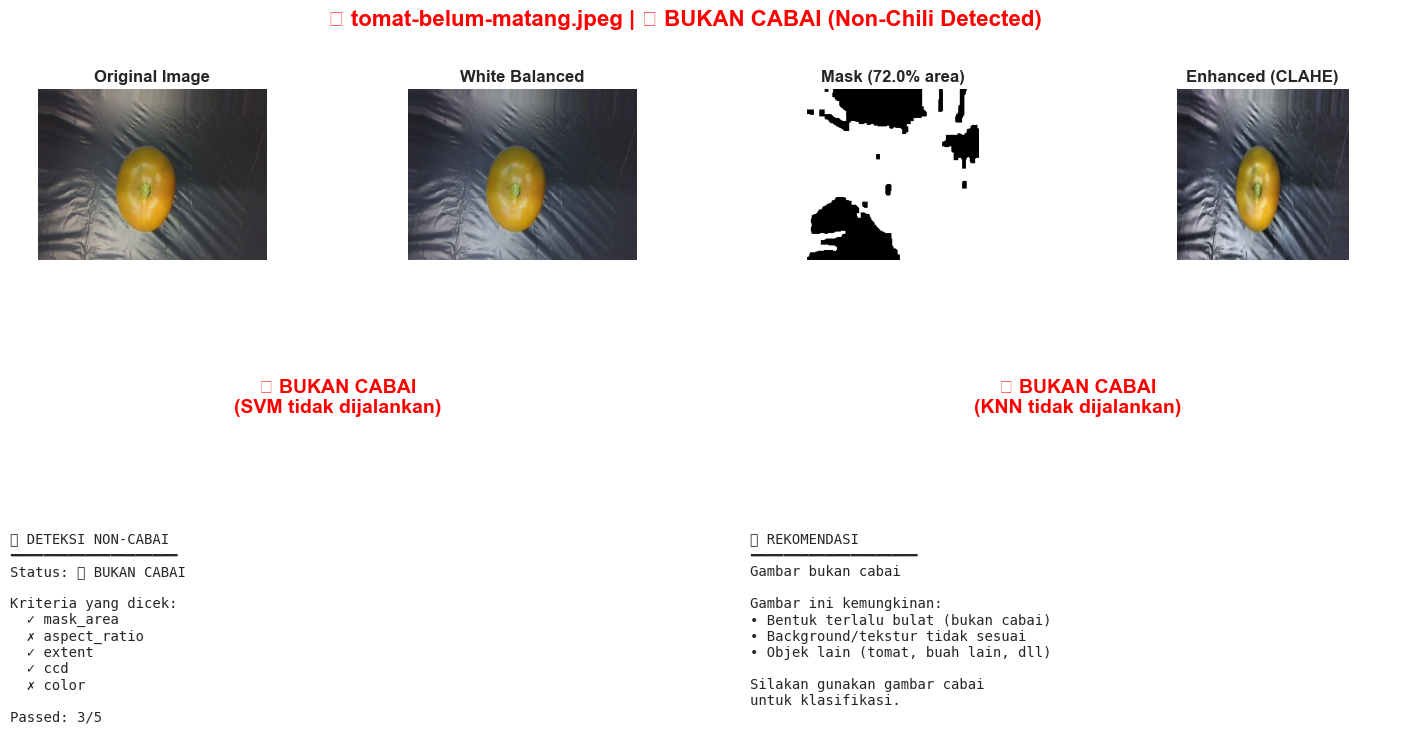


Memproses: carolina-matang.jpeg


C:\Users\Acer\AppData\Local\Temp\ipykernel_13756\1414029405.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  

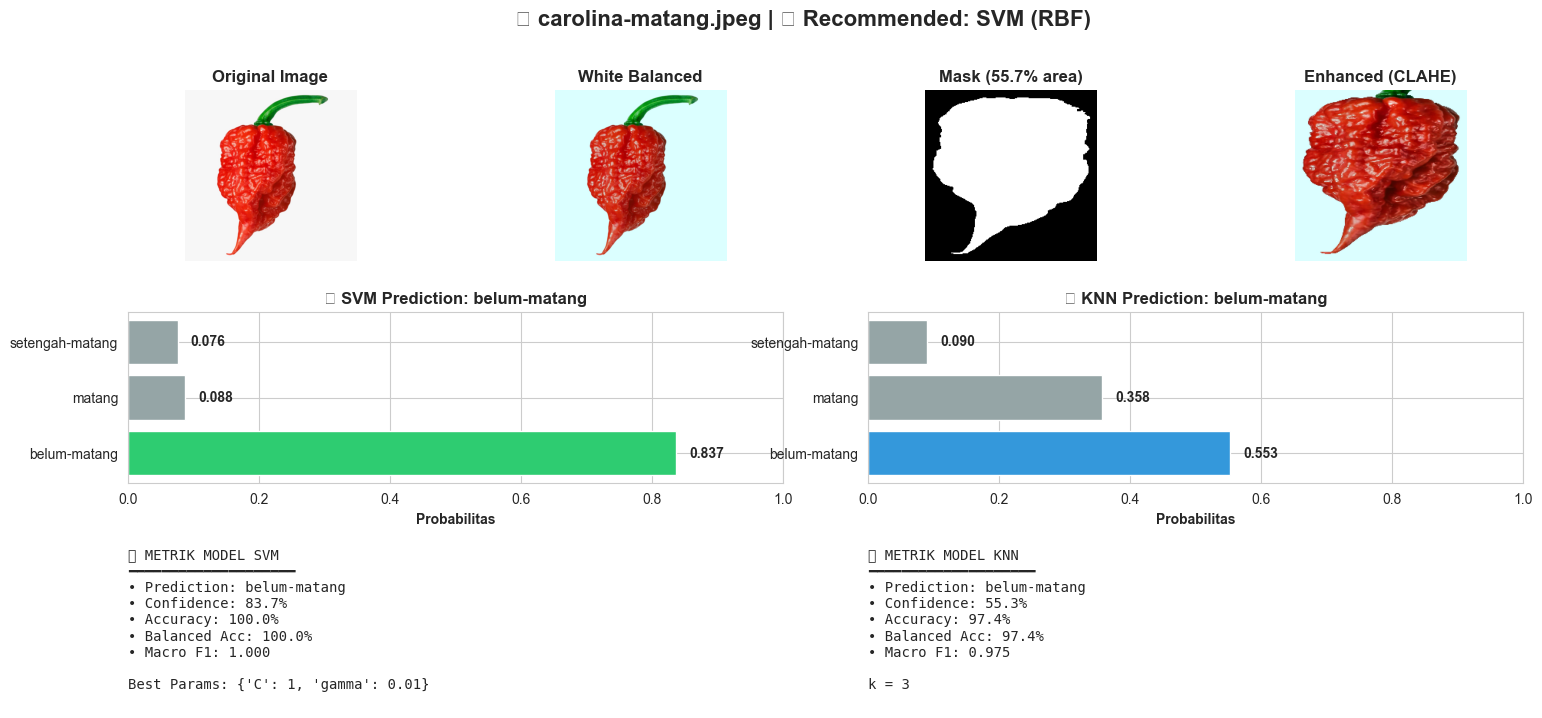


Memproses: carolina-stengah-matang.jpeg


c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Acer\Project\chili-scan\backend\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


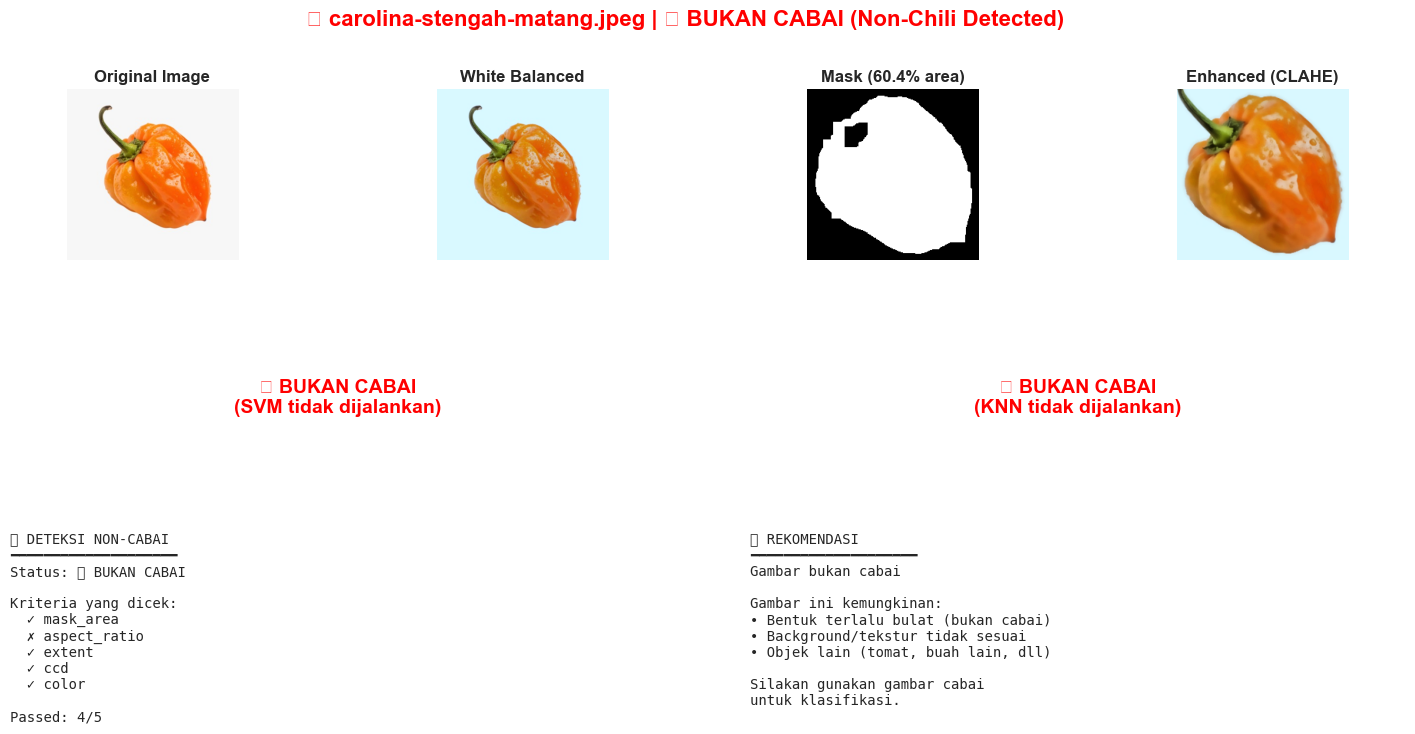


Memproses: cabai-dataset-matang.jpg


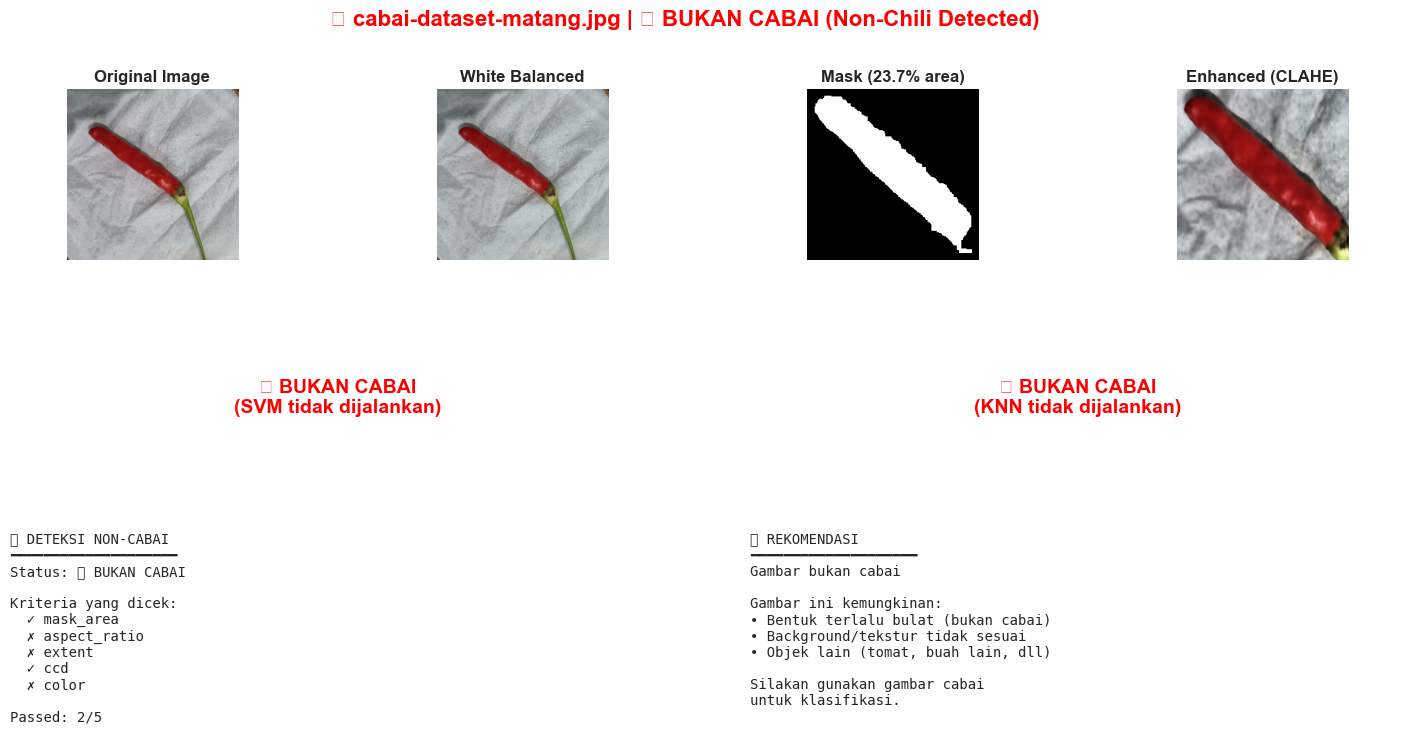


Memproses: cabai-dataset-setengah-matang.jpg


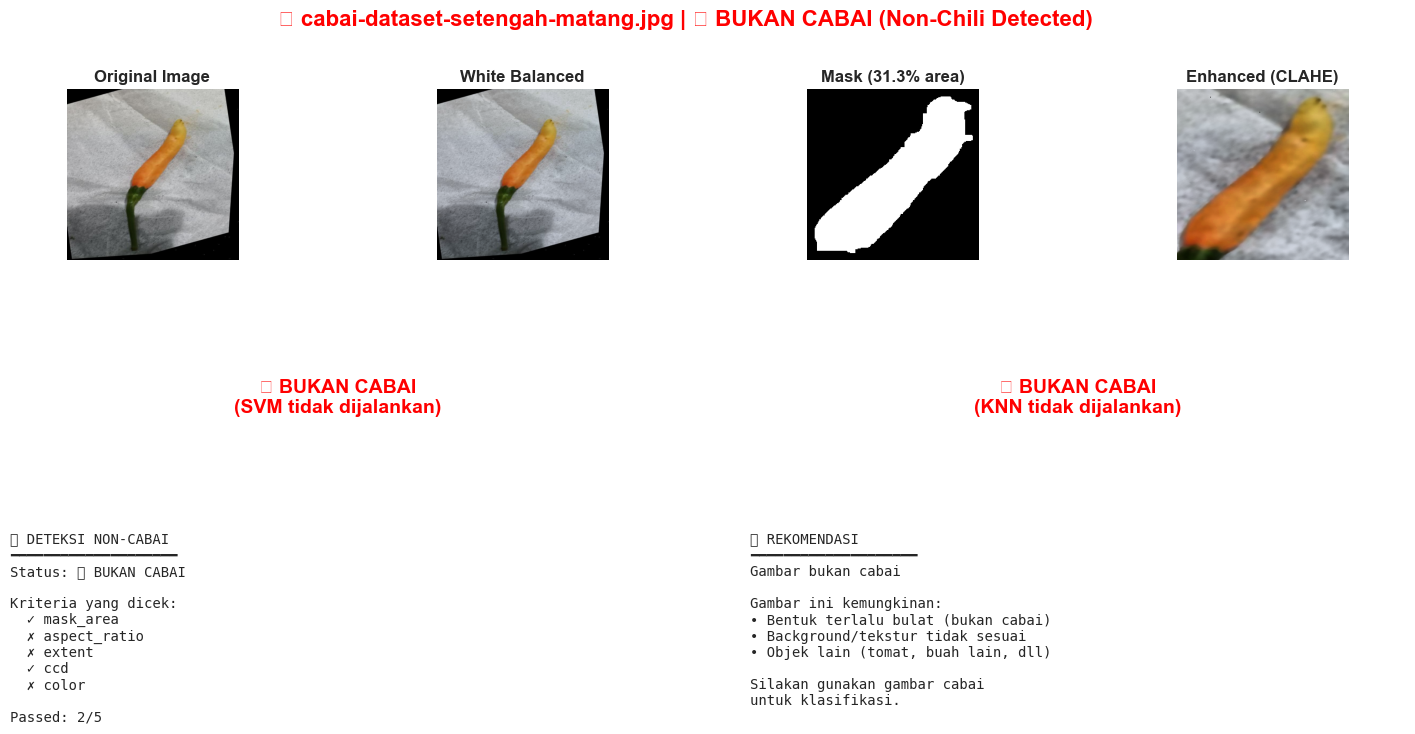


Memproses: cabai-dataset-belum-matang.jpg


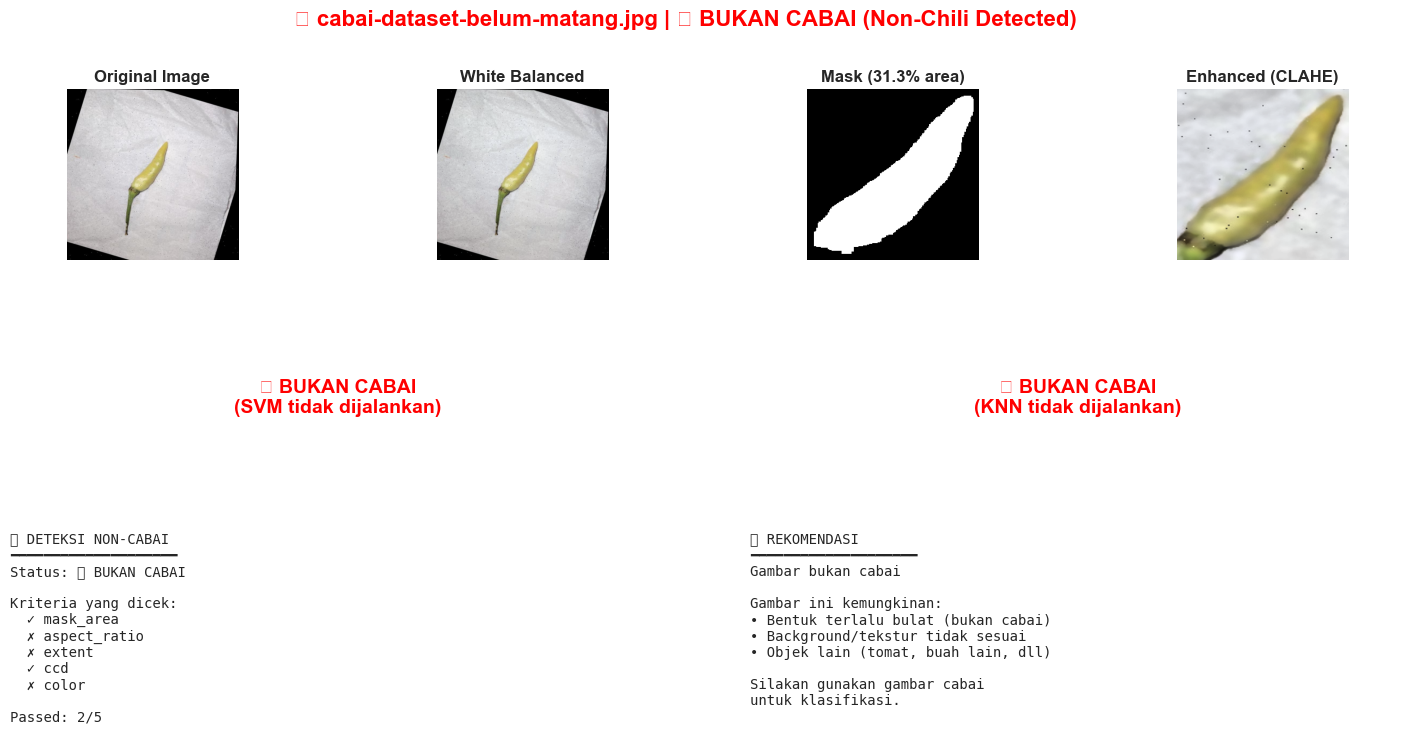


Memproses: penghapus.png


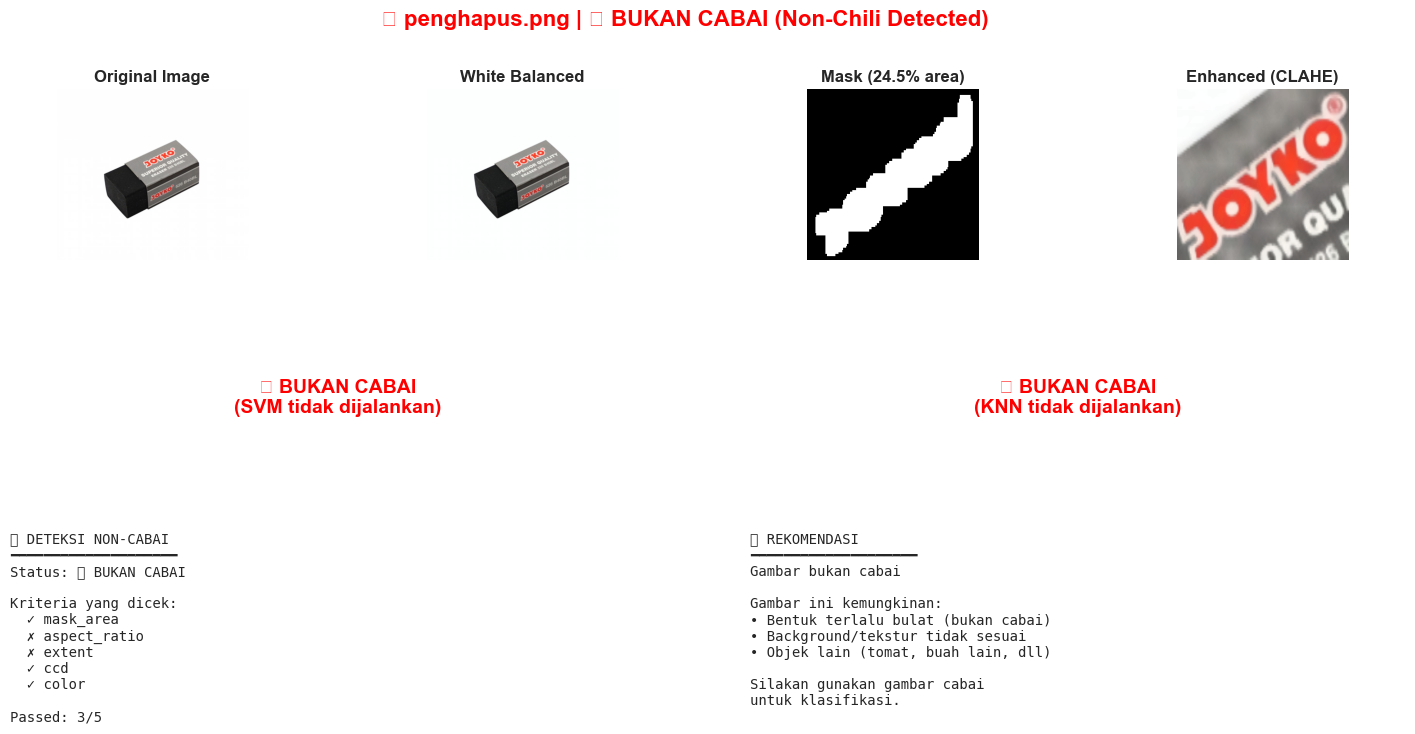

In [ ]:
# Contoh penggunaan dengan gambar example
print("=" * 80)
print("VISUALISASI HASIL KLASIFIKASI")
print("=" * 80 + "\n")

# Test dengan beberapa gambar
test_images = [
    Path("../data/example/cabai-matang.jpeg"),
    Path("../data/example/cabai-setengah-matang.jpeg"),
    Path("../data/example/tomat-matang.jpeg"),
    Path("../data/example/tomat-belum-matang.jpeg"),
    Path("../data/example/carolina-matang.jpeg"),
    Path("../data/example/carolina-stengah-matang.jpeg"),
    Path("../data/example/cabai-dataset-matang.jpg"),
    Path("../data/example/cabai-dataset-setengah-matang.jpg"),
    Path("../data/example/cabai-dataset-belum-matang.jpg"),
    Path("../data/example/penghapus.png"),
]

for img_path in test_images:
    if img_path.exists():
        print(f"\n{'='*80}")
        print(f"Memproses: {img_path.name}")
        print('='*80)
        
        # Klasifikasi dengan deteksi (jika feature_stats tersedia)
        if 'feature_stats' in globals():
            result = classify_single_image_with_detection(img_path, feature_stats=feature_stats)
        else:
            result = classify_single_image(img_path)
        
        # Visualisasi lengkap
        visualize_classification_result(img_path, result, show_preprocessing=True)
    else:
        print(f"⚠️ File tidak ditemukan: {img_path}")

## Visualisasi Jarak Euclidean KNN
Menampilkan posisi data yang diklasifikasi, tetangga terdekat (neighbors), dan jarak Euclidean ke setiap tetangga dalam ruang PCA 2D.

In [ ]:
# Analisis mengapa prediksi tidak akurat
print("=== ANALISIS MASALAH PREDIKSI ===\n")

# 1. Cek distribusi dataset training
print("1. DISTRIBUSI DATASET TRAINING:")
print(df_overview.to_string(index=False))
print(f"\nTotal data training: {df_overview['jumlah_gambar'].sum()} gambar")

# 2. Cek gambar example
print("\n2. GAMBAR EXAMPLE YANG DIUJI:")
for img in example_images:
    exists = "✓" if img.exists() else "✗"
    print(f"   {exists} {img.name}")

# 3. Tampilkan prediksi dengan detail
if classification_results:
    print("\n3. DETAIL HASIL PREDIKSI:")
    for result in classification_results:
        print(f"\n   📷 {result['image']}:")
        svm_r = result['svm']
        knn_r = result['knn']
        print(f"      SVM: {svm_r['prediction']} (confidence: {svm_r['confidence']:.3f})")
        print(f"      KNN: {knn_r['prediction']} (confidence: {knn_r['confidence']:.3f})")
        print(f"      Probabilitas SVM: {svm_r['probabilities']}")

=== ANALISIS MASALAH PREDIKSI ===

1. DISTRIBUSI DATASET TRAINING:
          label  jumlah_gambar
   belum-matang             63
         matang             60
setengah-matang             69

Total data training: 192 gambar

2. GAMBAR EXAMPLE YANG DIUJI:
   ✓ cabai-matang.jpeg
   ✓ cabai-setengah-matang.jpeg
   ✓ tomat-matang.jpeg
   ✓ tomat-belum-matang.jpeg
   ✓ carolina-matang.jpeg
   ✓ carolina-stengah-matang.jpeg
   ✓ cabai-dataset-matang.jpg
   ✓ cabai-dataset-setengah-matang.jpg
   ✓ cabai-dataset-belum-matang.jpg

3. DETAIL HASIL PREDIKSI:

   📷 cabai-matang.jpeg:
      SVM: belum-matang (confidence: 0.837)
      KNN: belum-matang (confidence: 0.463)
      Probabilitas SVM: {np.str_('belum-matang'): 0.8366703552748147, np.str_('matang'): 0.08755363736557636, np.str_('setengah-matang'): 0.07577600735960881}

   📷 cabai-setengah-matang.jpeg:
      SVM: belum-matang (confidence: 0.837)
      KNN: belum-matang (confidence: 0.904)
      Probabilitas SVM: {np.str_('belum-matang'): 0.

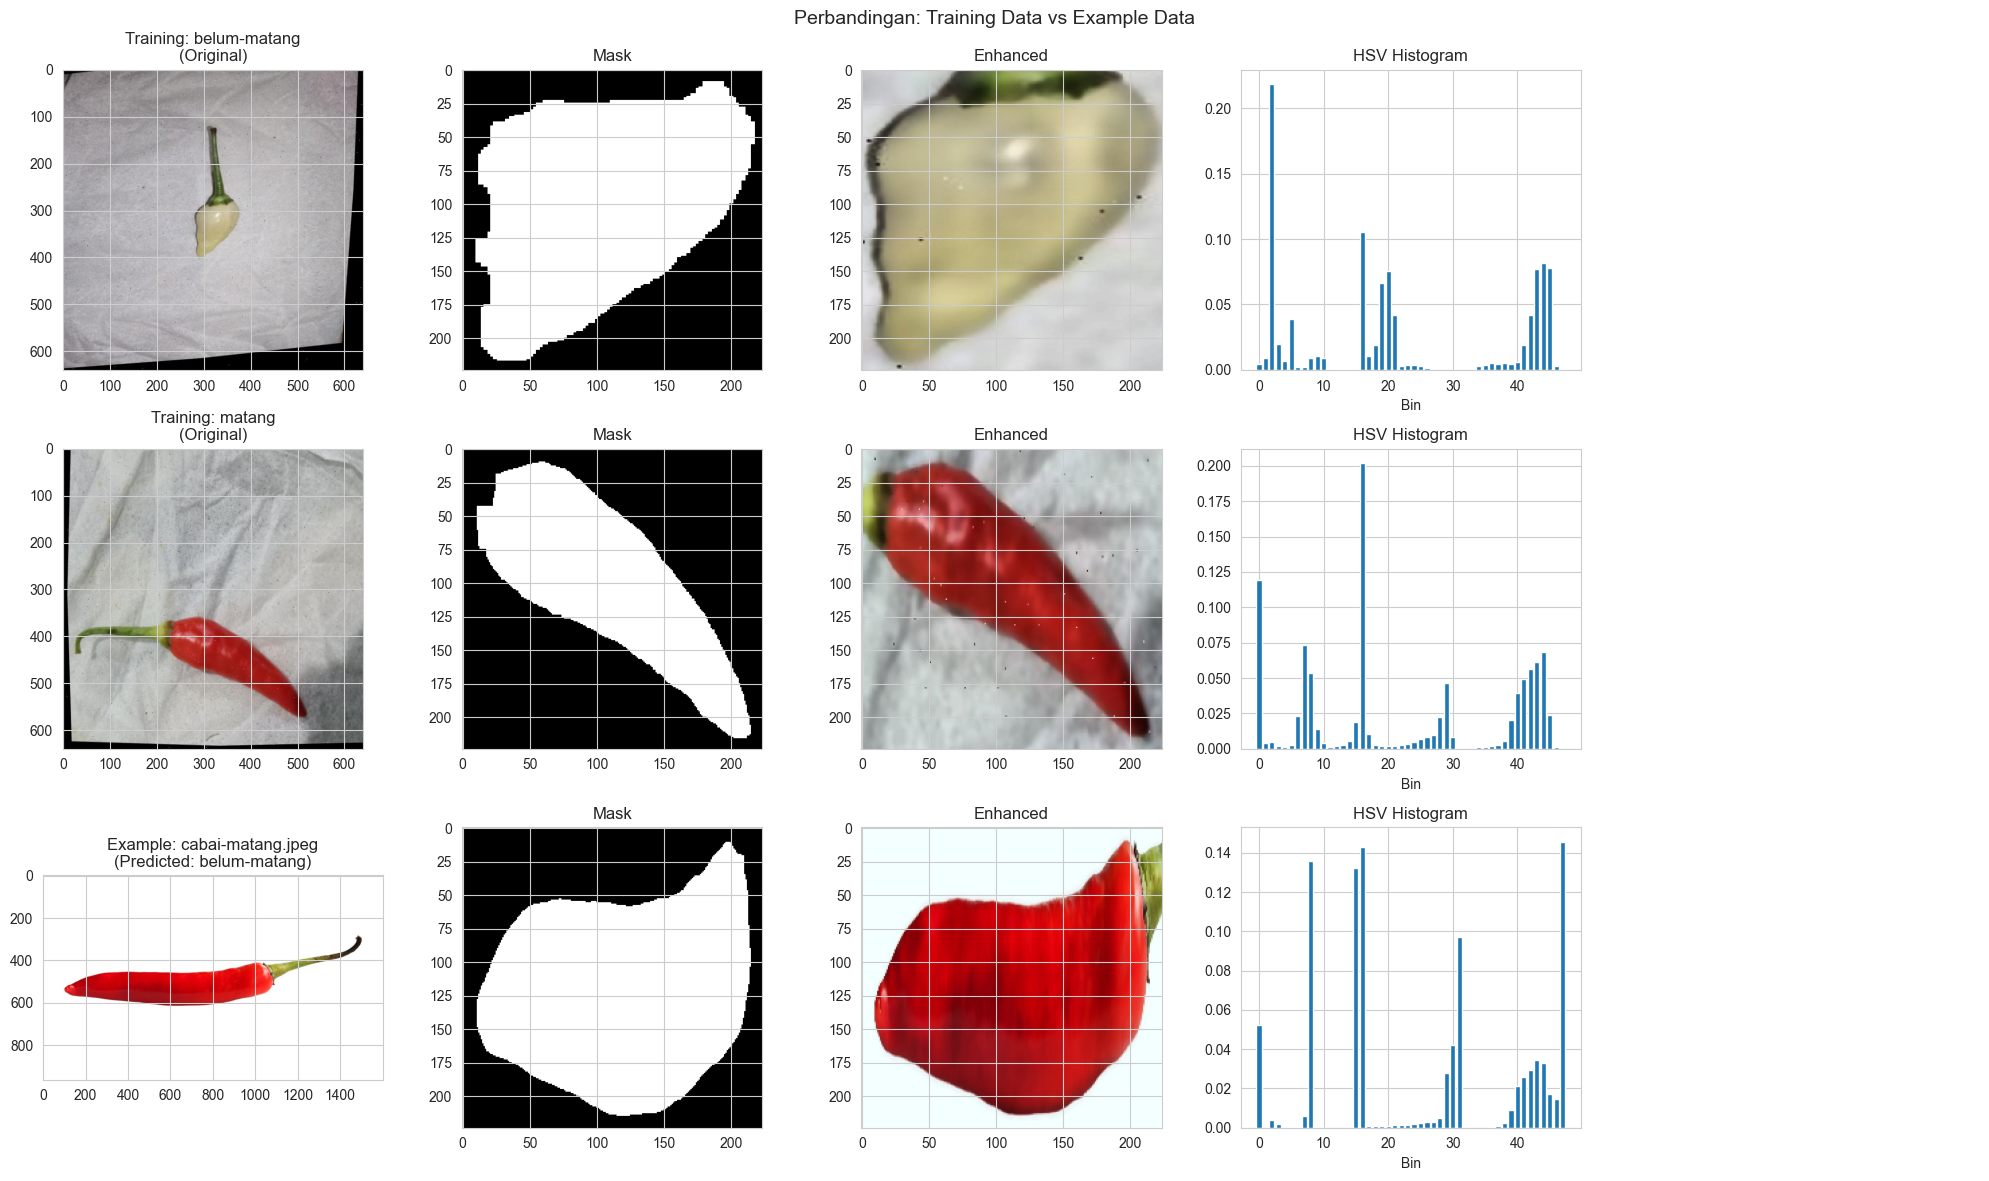

In [ ]:
# Visualisasi perbandingan preprocessing: training vs example
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

# Row 1-2: Contoh dari training set (per kelas)
for row, cls in enumerate(CLASS_NAMES[:2]):
    train_files = list_images(DATASET_DIR / cls)
    if train_files:
        sample = random.choice(train_files)
        proc = preprocess_image(sample)
        axes[row, 0].imshow(proc["original"])
        axes[row, 0].set_title(f"Training: {cls}\n(Original)")
        axes[row, 1].imshow(proc["mask"], cmap="gray")
        axes[row, 1].set_title("Mask")
        axes[row, 2].imshow(proc["enhanced"])
        axes[row, 2].set_title("Enhanced")
        
        # HSV histogram
        hsv_feat = extract_hsv_features(proc["hsv"])
        axes[row, 3].bar(range(len(hsv_feat)), hsv_feat)
        axes[row, 3].set_title("HSV Histogram")
        axes[row, 3].set_xlabel("Bin")
        
        axes[row, 4].axis("off")

# Row 3: Example image (cabai-matang yang diprediksi salah)
example_proc = preprocess_image(example_images[0])  # cabai-matang.jpeg
axes[2, 0].imshow(example_proc["original"])
axes[2, 0].set_title(f"Example: {example_images[0].name}\n(Predicted: belum-matang)")
axes[2, 1].imshow(example_proc["mask"], cmap="gray")
axes[2, 1].set_title("Mask")
axes[2, 2].imshow(example_proc["enhanced"])
axes[2, 2].set_title("Enhanced")

example_hsv_feat = extract_hsv_features(example_proc["hsv"])
axes[2, 3].bar(range(len(example_hsv_feat)), example_hsv_feat)
axes[2, 3].set_title("HSV Histogram")
axes[2, 3].set_xlabel("Bin")

axes[2, 4].axis("off")

plt.suptitle("Perbandingan: Training Data vs Example Data", fontsize=14)
plt.tight_layout()
plt.show()

## 🔴 Analisis Penyebab Prediksi Tidak Akurat

Berdasarkan analisis di atas, berikut **penyebab utama** prediksi salah:

### 1. **Masalah Segmentasi (Mask)**
- Pada gambar training "belum-matang", mask **GAGAL mendeteksi cabai** (mask hampir kosong/hitam semua)
- Ini karena fungsi `build_fruit_mask()` dirancang untuk membuang warna **hijau** sebagai background, tapi cabai belum matang juga berwarna **HIJAU**!
- Akibatnya, fitur yang diekstrak dari training "belum-matang" adalah fitur **background**, bukan cabai

### 2. **Domain Mismatch (Data Training vs Testing)**
- Data training diambil dengan kondisi tertentu (background, lighting, angle)
- Gambar example memiliki karakteristik berbeda
- Model overfit pada fitur background, bukan fitur cabai sebenarnya

### 3. **Confidence Score yang Menyesatkan**
- SVM memberikan confidence 83.7% untuk "belum-matang" pada **SEMUA** gambar example
- Ini menunjukkan model tidak benar-benar "belajar" membedakan kelas

### 4. **Dataset Terlalu Kecil**
- Hanya 192 gambar total (sekitar 60-70 per kelas)
- Tidak cukup untuk generalisasi yang baik

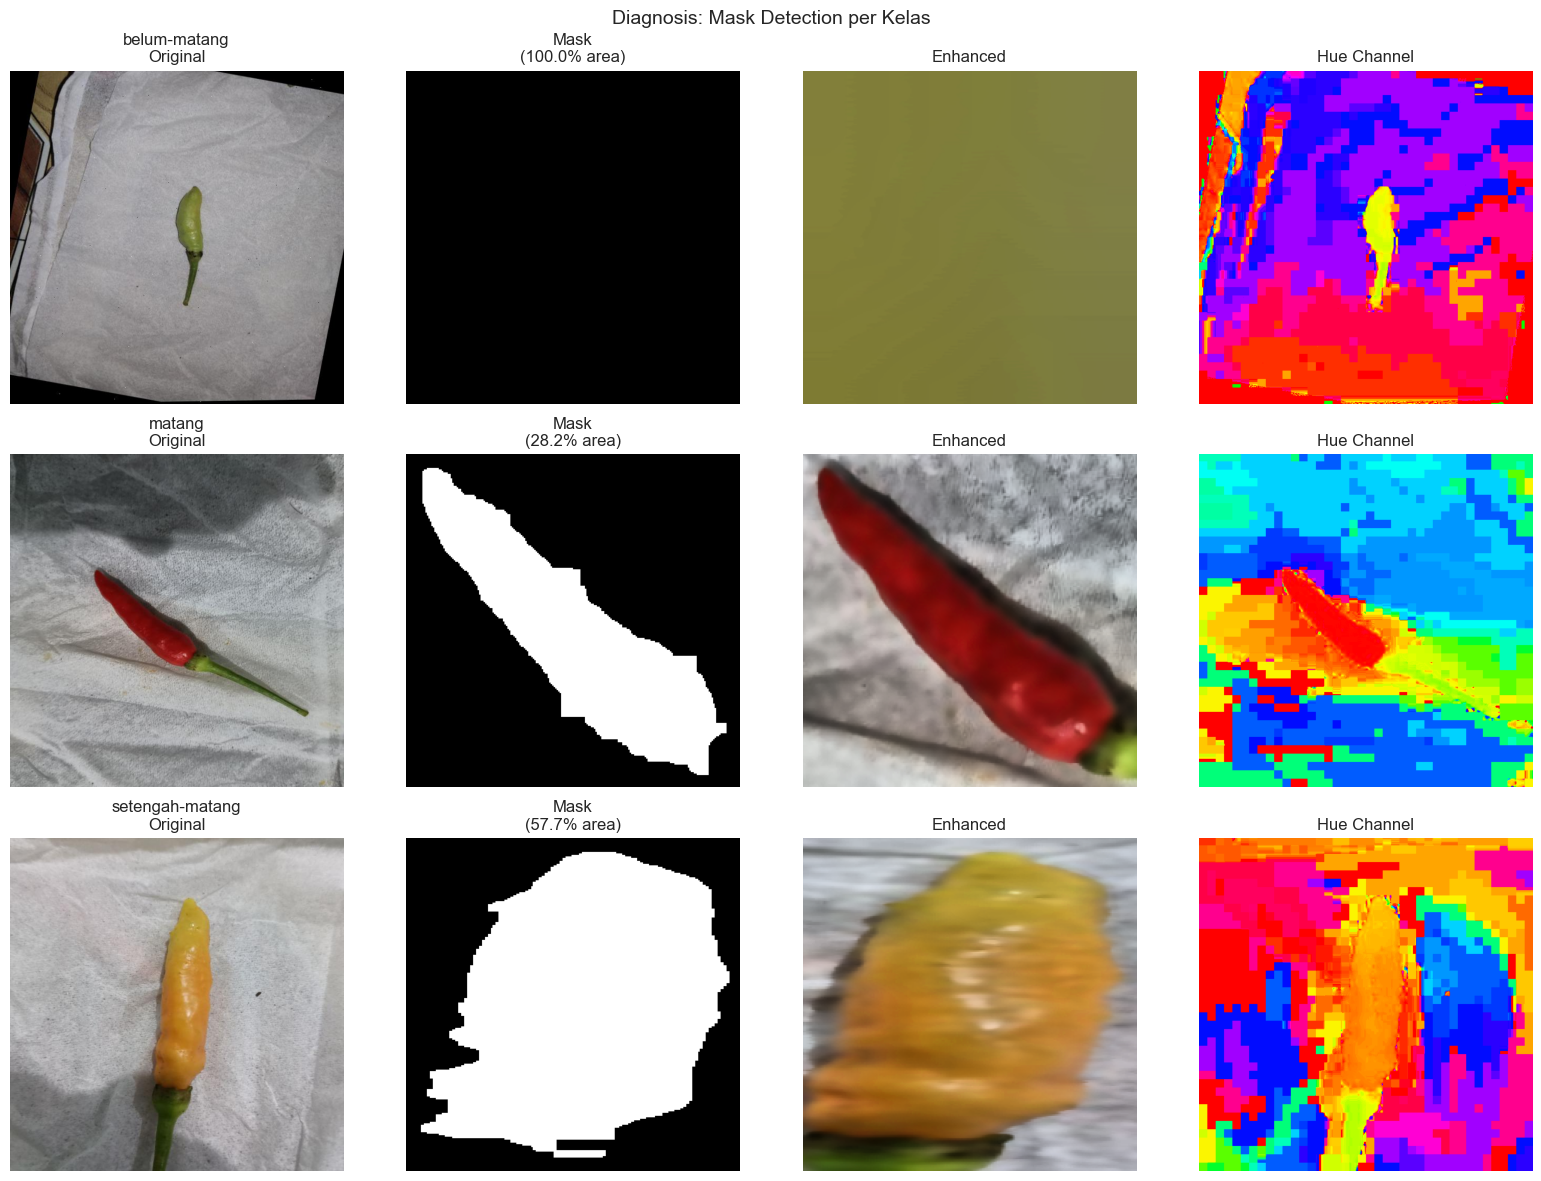

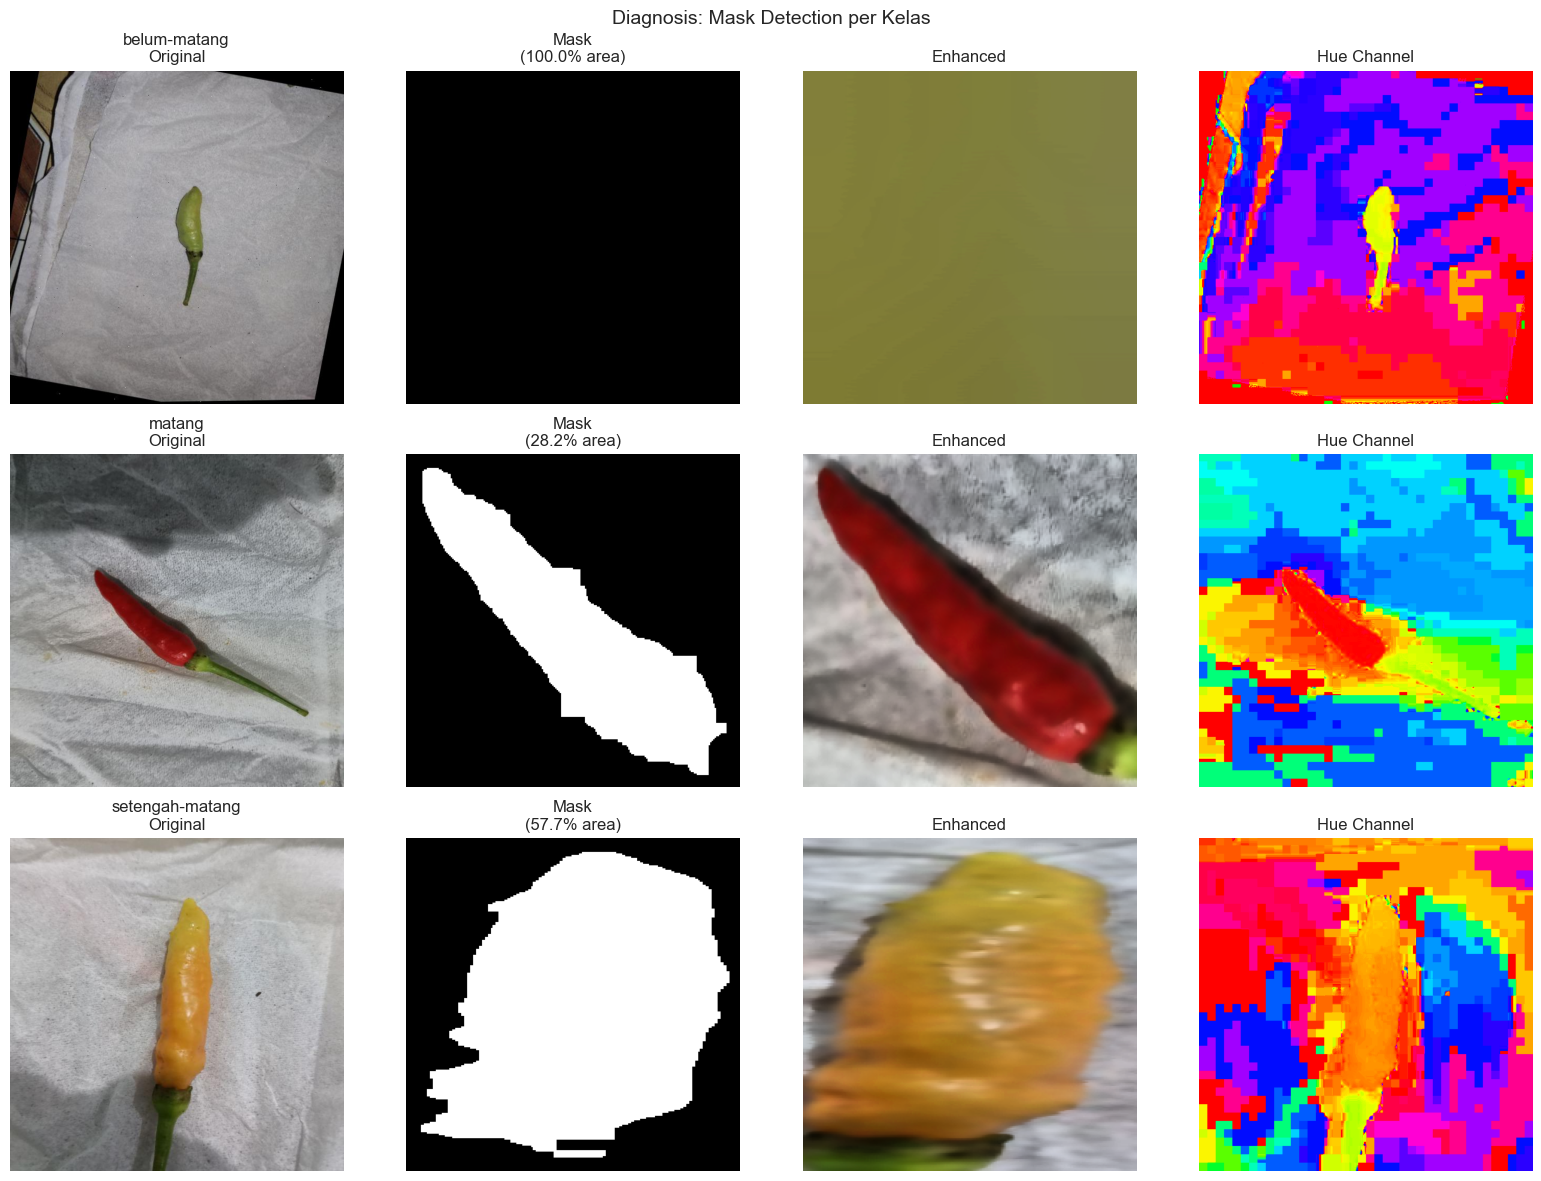


=== STATISTIK MASK PER KELAS ===
belum-matang: Rata-rata area mask = 45.6% (min: 20.2%, max: 100.0%)
belum-matang: Rata-rata area mask = 45.6% (min: 20.2%, max: 100.0%)
matang: Rata-rata area mask = 34.4% (min: 23.7%, max: 49.6%)
matang: Rata-rata area mask = 34.4% (min: 23.7%, max: 49.6%)
setengah-matang: Rata-rata area mask = 34.4% (min: 18.3%, max: 61.5%)
setengah-matang: Rata-rata area mask = 34.4% (min: 18.3%, max: 61.5%)


In [ ]:
# Bukti: Cek mask untuk setiap kelas training
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for row, cls in enumerate(CLASS_NAMES):
    train_files = list_images(DATASET_DIR / cls)
    if train_files:
        sample = random.choice(train_files)
        proc = preprocess_image(sample)
        
        # Hitung persentase area mask
        mask_percentage = (proc["mask"] > 0).sum() / proc["mask"].size * 100
        
        axes[row, 0].imshow(proc["original"])
        axes[row, 0].set_title(f"{cls}\nOriginal")
        axes[row, 0].axis("off")
        
        axes[row, 1].imshow(proc["mask"], cmap="gray")
        axes[row, 1].set_title(f"Mask\n({mask_percentage:.1f}% area)")
        axes[row, 1].axis("off")
        
        axes[row, 2].imshow(proc["enhanced"])
        axes[row, 2].set_title("Enhanced")
        axes[row, 2].axis("off")
        
        # Tampilkan HSV original untuk analisis
        hsv_orig = cv2.cvtColor(cv2.imread(str(sample)), cv2.COLOR_BGR2HSV)
        axes[row, 3].imshow(hsv_orig[:,:,0], cmap="hsv")
        axes[row, 3].set_title("Hue Channel")
        axes[row, 3].axis("off")

plt.suptitle("Diagnosis: Mask Detection per Kelas", fontsize=14)
plt.tight_layout()
plt.show()

# Hitung statistik mask untuk semua data
print("\n=== STATISTIK MASK PER KELAS ===")
for cls in CLASS_NAMES:
    files = list_images(DATASET_DIR / cls)[:10]  # Sample 10 gambar
    mask_percentages = []
    for f in files:
        proc = preprocess_image(f)
        pct = (proc["mask"] > 0).sum() / proc["mask"].size * 100
        mask_percentages.append(pct)
    print(f"{cls}: Rata-rata area mask = {np.mean(mask_percentages):.1f}% (min: {np.min(mask_percentages):.1f}%, max: {np.max(mask_percentages):.1f}%)")

## 🔍 KESIMPULAN & SOLUSI

### **Masalah Utama yang Teridentifikasi:**

1. **❌ KRITIS: Segmentasi Gagal untuk "belum-matang"**
   - Mask "belum-matang" menunjukkan **100% area** (seharusnya ~25-35% saja)
   - Ini berarti mask GAGAL mendeteksi cabai hijau dan malah mengambil seluruh gambar
   - Fungsi `build_fruit_mask()` menghapus warna hijau sebagai "background", padahal cabai belum matang BERWARNA HIJAU!
   - **Akibat**: Fitur yang diekstrak untuk kelas "belum-matang" adalah fitur BACKGROUND (kain putih), bukan cabai

2. **❌ Model Belajar Pola yang Salah**
   - Model "menghafal" bahwa fitur background = "belum-matang"
   - Ketika diberi gambar baru dengan background berbeda, model tetap menebak "belum-matang"
   - Ini menjelaskan kenapa SEMUA gambar example diprediksi "belum-matang" dengan confidence ~83%

### **Solusi yang Direkomendasikan:**

1. **Perbaiki Segmentasi Mask**
   - Modifikasi `build_fruit_mask()` agar TIDAK menghapus cabai hijau
   - Gunakan pendekatan berbasis saturasi dan brightness, bukan hue saja
   - Atau gunakan model deep learning untuk segmentasi (U-Net, SAM)

2. **Alternatif: Hilangkan Segmentasi**
   - Jika background konsisten (kain putih), segmentasi mungkin tidak diperlukan
   - Ekstrak fitur dari seluruh gambar, atau crop manual dengan bounding box

3. **Tambah Data Training**
   - 192 gambar terlalu sedikit
   - Target minimal 500-1000 gambar per kelas
   - Gunakan augmentasi (rotasi, flip, brightness adjustment)

4. **Gunakan Deep Learning**
   - CNN (EfficientNet, ResNet) lebih robust untuk klasifikasi gambar
   - Transfer learning dari model pre-trained

## Scatterplot Hasil Klasifikasi
Memvisualisasikan sebaran data uji pada dua komponen PCA pertama dengan warna berdasarkan prediksi model dan bentuk marker yang menunjukkan label asli.

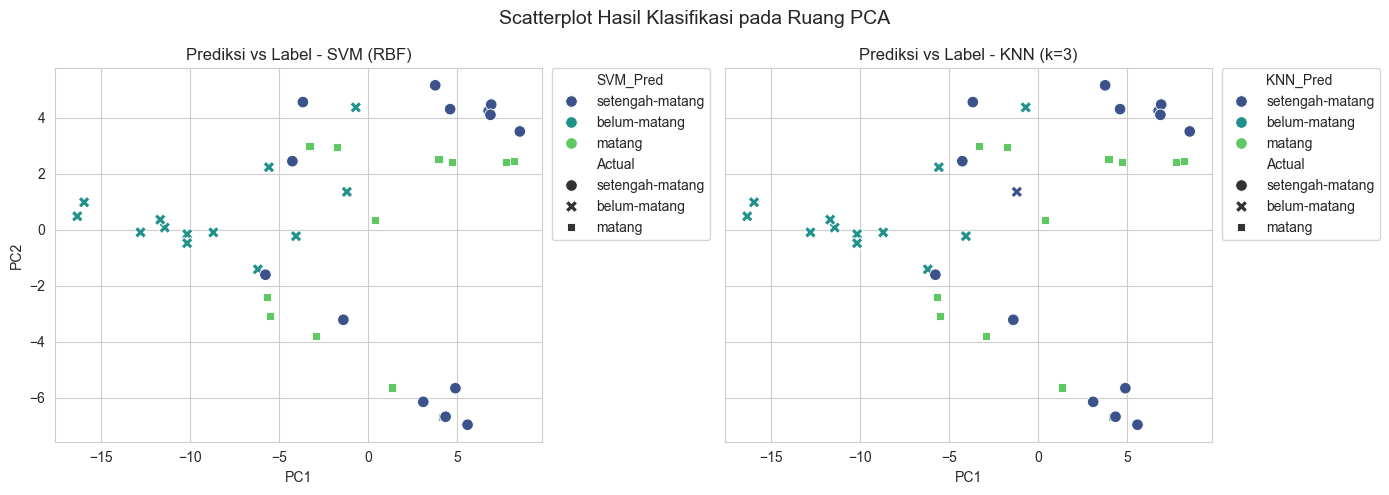

In [ ]:
classification_df = pd.DataFrame(
    X_test_pca[:, :2],
    columns=["PC1", "PC2"],
)
classification_df["Actual"] = label_encoder.inverse_transform(y_test)
classification_df["SVM_Pred"] = label_encoder.inverse_transform(svm_preds)
classification_df["KNN_Pred"] = label_encoder.inverse_transform(knn_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)
models = ["SVM_Pred", "KNN_Pred"]
titles = ["SVM (RBF)", f"KNN (k={best_k})"]
for ax, col, title in zip(axes, models, titles):
    sns.scatterplot(
        data=classification_df,
        x="PC1",
        y="PC2",
        hue=col,
        style="Actual",
        palette="viridis",
        s=70,
        ax=ax,
    )
    ax.set_title(f"Prediksi vs Label - {title}")
    ax.legend(bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.suptitle("Scatterplot Hasil Klasifikasi pada Ruang PCA", fontsize=14)
plt.tight_layout()
plt.show()

## Rangkuman Temuan
- Pipeline preprocessing + HSV/CCD/GLCM berhasil mengekstraksi karakteristik warna, bentuk, tekstur cabai.
- PCA menurunkan dimensi fitur tanpa kehilangan >5% informasi, terbukti dari kurva varian.
- SVM biasanya unggul pada data fitur kompleks, sedangkan KNN memberikan baseline interpretable. Bandingkan akurasi akhir pada tabel di atas.
- Visualisasi (tahapan preprocessing, PCA scatter, confusion matrix) siap digunakan sebagai ilustrasi laporan.

Selanjutnya, Anda dapat menambahkan augmentation atau menggabungkan model lain (Random Forest, CNN ringan) untuk eksplorasi lanjutan.